In [18]:
# 这里采用传统火电机组的方案,传统火电机组
# 注释掉关于SMR的部分约束
# 修改成本参数
# 增加环境成本
# ***这里仍有一种可能,尽管引入了环境成本,但相比于SMR的投资成本,仍然不是最优***
# the first time to integrate the large iteration process
# rewrite the small iteration process as a function
# 这里对不同碳税下的传统火电机组规划问题做灵敏度分析，得到成本随着碳税增长的曲线，得出当未来碳税高于某一值的时候，SMR的经济可行性可以得到保证

In [19]:
import time
import numpy as np
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
# cluster the load into different groups
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import manifold
from sklearn.metrics.pairwise import pairwise_distances

In [20]:
# df_pv_original = pd.read_csv("data/day_PV_original.csv", header=None)
# pv_original = df_pv_original.values
# pv_max_value = np.max(pv_original)
# pv_data = pv_original/pv_max_value
# pv_data_save = pd.DataFrame(pv_data)
# pv_data_save.to_csv('data/day_pv.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [21]:
import os
os.environ['LD_LIBRARY_PATH'] += '/home/hmy/matlabrt/v912/runtime/glnxa64:/home/hmy/matlabrt/v912/bin/glnxa64:/home/hmy/matlabrt/v912/sys/os/glnxa64:/home/hmy/matlabrt/v912/extern/bin/glnxa64'
import f_find_nadir
find_nadir = f_find_nadir.initialize()

In [22]:
# from net_load data to get the cluster related variables
class cluster_net_load:
    def __init__(self, net_load):
        self.net_load = net_load
        
    def get_cluster(self):
        k = 8
        kmeans = KMeans(n_clusters=k, random_state = 42)
        kmeans = KMeans(n_clusters=k)
        y_pred = kmeans.fit_predict(self.net_load)
        centers = kmeans.cluster_centers_ 
        period_day_num = 0
        
        # get period
        cluster = y_pred[0]
        temp1 = []
        temp2 = []
        for i in range(len(y_pred)):
            if y_pred[i] == cluster:
                period_day_num = period_day_num+1
            else:
                temp1.append(period_day_num)
                temp2.append(cluster)
                cluster = y_pred[i]
                period_day_num = 1
        temp1.append(period_day_num)
        temp2.append(cluster)

        period = []
        period.append(temp1)
        period.append(temp2)
        period = np.array(period)
        period_data = pd.DataFrame(period)
        period_data.to_csv('data/period.csv', sep= ',', encoding='utf-8', header=False, index=False)
        
        # get cluster day_index and cluster day_num 
        data_cen = np.r_[self.net_load, centers]
        k = len(centers)
        closest_ind = np.arange(k)
        dist = pairwise_distances(data_cen, metric='euclidean')
        for i in range(k):
            closest_ind_tmp = np.where(dist[0:-k, -i-1] == np.min(dist[0:-k, -i-1]))
            closest_ind[i] = closest_ind_tmp[0][0]

        center_day = closest_ind+1
        # reverse
        center_day = center_day[::-1]
        
        cluster_day_num = []
        for cluster in range(0, k):
            day_cluster = np.argwhere(y_pred==cluster)
            cluster_day_num.append(len(day_cluster))
        cluster_day_num = np.array(cluster_day_num)
        
        cluster_day = []
        cluster_day.append(center_day)
        cluster_day.append(cluster_day_num)
        cluster_day = np.array(cluster_day)
        
        cluster_day_data = pd.DataFrame(cluster_day)
        cluster_day_data.to_csv('data/cluster_day.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [23]:
# 由于每一次外环迭代都会重新聚类，因此有必要对每一次外环迭代的聚类cluster_day以及period进行保存
# 需要调整程序

In [24]:
# boundary: load, renewable, representative days
class read_data:
    def __init__(self, file_list:list):
        self.file_list = file_list
        
    def get_data(self):
        # load data
        df_load = pd.read_csv(self.file_list[0], header=None)
        load = df_load.values
        # pv data
        df_pv = pd.read_csv(self.file_list[1], header=None)
        pv = df_pv.values
        # cluster_day
        df_cluster_day = pd.read_csv(self.file_list[2], header=None)
        cluster_day = df_cluster_day.values[0]
        cluster_day_num = df_cluster_day.values[1]
        # cluster period
        df_period = pd.read_csv(self.file_list[3], header=None)
        period = df_period.values
        # representative days
        day_num = len(cluster_day)
        day_load = []
        day_pv = []
        for day in range(day_num):
            day_load.append(load[cluster_day[day]-1])
            day_pv.append(pv[cluster_day[day]-1])
            
        day_load = np.array(day_load)
        day_pv = np.array(day_pv)
        
        return day_load, day_pv, cluster_day_num, period

In [25]:
# small module reactors
class small_modular_reactor:
    def __init__(self, invest_decision, cap, output, output_max, output_min, output_change,
                 change_temp, adjust_num, inv_cost, ope_cost, cluster_day_num, period, SMR_droop):
        # number of SMR invested
        self.invest_decision = invest_decision
        # SMR capacity
        self.cap = cap
        # upper
        self.pmax = cap
        # lower
        self.pmin = 0.4*cap
        # RU
        self.RU = 0.4*cap
        # RD
        self.RD = 0.4*cap
        # SMR hourly output
        self.output = output
        # output max
        self.output_max = output_max
        # output min
        self.output_min = output_min
        # output_change
        self.output_change = output_change
        # abs auxiliary variable
        self.change_temp = change_temp
        # adjustments
        self.adjust_num = adjust_num
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period
        self.period = period
        # droop for freuency response
        self.droop = SMR_droop
        
    def get_SMR_cost(self):
        # investment cost
        SMR_inv_cost = self.inv_cost*self.cap*cvx.sum(self.invest_decision)
        day_num = len(self.output)
        SMR_num = self.output[0].shape[0]
        hour_num = self.output[0].shape[1]
        # operation cost
        SMR_ope_cost = 0
        SMR_reserve_cost = 0
        # 模拟火电机组,对碳排放成本进行折算
        SMR_carbon_cost = 0
        for day_index in range(day_num):
            p = self.output[day_index]
            droop = self.droop[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                for k in range(SMR_num):
                    SMR_reserve = droop[k, t]*0.8
                    SMR_ope_cost = SMR_ope_cost + self.ope_cost*p[k, t]*day_index_num
                    SMR_reserve_cost = SMR_reserve_cost + 0*SMR_reserve*day_index_num
                    # 碳税给20的情况下，由于0.9tCO2/MWh，得到换算成美元的折算率
                    # 在上述情况下，碳成本甚至小于运行成本，因此考虑扩大碳税为原来的10倍，即这里的折算率改为180
                    # 扩大10倍带来的影响太大了，考虑改成90
                    # 这里是碳税给20的折算情况
                    SMR_carbon_cost = SMR_carbon_cost + 36*p[k, t]*day_index_num
        
        return SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost, SMR_carbon_cost
    
    def get_SMR_cons(self):
        M = 500
        B = 1e-6
        cons = []
        day_num = len(self.output)
        hour_num = self.output[0].shape[1]
        SMR_num = self.output[0].shape[0]
        for day_index in range(day_num):
            p = self.output[day_index]
            p_min = self.output_min[day_index]
            p_max = self.output_max[day_index]
            z = self.output_change[day_index]
            ut = self.change_temp[day_index]
            zt = self.adjust_num[day_index]
            droop = self.droop[day_index]
            # upper, lower limits
            for t in range(hour_num):
                for k in range(SMR_num):
                    # reserve at the time step, maximum frequency deviation
                    SMR_reserve = droop[k,t]*0.8
                    cons += [SMR_reserve >= 0]
                    cons += [SMR_reserve <= 0.1*self.cap*self.invest_decision[k]]
                    cons += [p[k,t] >= (0.4*self.cap)*self.invest_decision[k]]
                    cons += [p[k,t] <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] + SMR_reserve) <= (self.cap)*self.invest_decision[k]]
                    cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # cons += [(p[k,t] - SMR_reserve) >= (0.4*self.cap)*self.invest_decision[k]]
                    # # maxmimum power output linearization
                    # cons += [p_max[k,t] >= (SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_max[k,t] <= (self.cap - SMR_reserve)]
                    # cons += [p_max[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_max[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] <= (p_max[k,t])]
                    # # minmimum power output linearization
                    # cons += [p_min[k,t] >= (0.4*self.cap + SMR_reserve) - (1 - self.invest_decision[k])*M]
                    # cons += [p_min[k,t] <= (0.4*self.cap + SMR_reserve)]
                    # cons += [p_min[k,t] <= self.invest_decision[k]*M]
                    # cons += [p_min[k,t] >= -self.invest_decision[k]*M]
                    # cons += [p[k,t] >= (p_min[k,t])]
            for k in range(SMR_num):
                for t in range(1, hour_num):
                    cons += [p[k,t]-p[k,t-1] <= self.RU]
                    cons += [p[k,t-1]-p[k,t] <= self.RD]
                #     cons += [p[k,t]-p[k,t-1] <= z[k,t]]
                #     cons += [p[k,t-1]-p[k,t] <= z[k,t]]
                #     cons += [z[k,t] <= (p[k,t]-p[k,t-1] + (1-ut[k,t])*M)]
                #     cons += [z[k,t] <= (p[k,t-1]-p[k,t] + ut[k,t]*M)]
                #     cons += [z[k,t] <= zt[k,t]*M]
                #     cons += [z[k,t] >= (zt[k,t]-1)*M + B]
                # # the number of adjustemn at each day is limitted
                # cons += [cvx.sum(zt[k, :]) <= 4]
        # the inter-day output should also within ramp up/down limits
        for day_index in range(day_num):
            p = self.output[day_index]
            for k in range(SMR_num):
                cons += [p[k, 0]-p[k, -1] <= self.RU]
                cons += [p[k, -1]-p[k, 0] <= self.RD]
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        for period_index in range(1, period_num):
            cluster_index = self.period[1][period_index]
            cluster_index_last = self.period[1][period_index-1]
            p = self.output[cluster_index]
            p_last = self.output[cluster_index_last]
            for k in range(SMR_num):
                cons += [p[k, 0]-p_last[k, -1] <= self.RU]
                cons += [p_last[k, -1]-p[k, 0] <= self.RD]
        
        return cons

In [26]:
# Photovoltaics
class Photovoltaic:
    def __init__(self, invest_decision, Cap_limit, day_pv, output, output_cut,
                 inv_cost, ope_cost, cluster_day_num, PV_droop, PV_inertia):
        # PV capacity
        self.cap = invest_decision
        # PV capacity limit
        self.cap_limit = Cap_limit
        # day output
        self.day_output = day_pv
        # upper
        self.pmax = self.cap
        # lower
        self.pmin = 0
        # daily output variable
        self.output = output
        # daily curtailment variable
        self.output_cut = output_cut
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        self.droop = PV_droop
        # virtual inertia
        self.inertia = PV_inertia
        
    def get_PV_cost(self):
        # investment cost
        PV_inv_cost = self.inv_cost*self.cap
        day_num = self.output.shape[0]
        hour_num = self.output.shape[1]
        # operation cost
        PV_ope_cost = 0
        PV_reserve_cost = 0
        for day_index in range(day_num):
            pv = self.output[day_index]
            day_index_num = self.cluster_day_num[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                PV_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                PV_ope_cost = PV_ope_cost + self.ope_cost*pv[t]*day_index_num
                PV_reserve_cost = PV_reserve_cost + 0*PV_reserve*day_index_num
        return PV_inv_cost, PV_ope_cost, PV_reserve_cost
        
    def get_PV_cons(self):
        cons = []
        day_num = self.output.shape[0]
        hour_num = self.output.shape[1]
        cons += [self.cap <= self.cap_limit]
        cons += [self.cap >= 0]
        for day_index in range(day_num):
            pv_day_output = self.day_output[day_index]
            pv = self.output[day_index]
            pv_c = self.output_cut[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                # PV reserve 
                PV_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                cons += [inertia[t] >= 0]
                cons += [droop[t] >= 0]
                cons += [PV_reserve <= 0.1*pv_day_output[t]*self.pmax]
                cons += [pv[t] >= pv_day_output[t]*self.pmin]
                cons += [pv[t] <= pv_day_output[t]*self.pmax]
                cons += [pv_c[t] >= 0]
                cons += [pv_c[t] <= pv_day_output[t]*self.pmax]
                cons += [(pv[t] + PV_reserve + pv_c[t])  == pv_day_output[t]*self.pmax]
        
        return cons

In [27]:
# Battery energy storage 
class Battery_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, BESS_gamma, eta_c, eta_d,
                 SOC, charge_state, discharge_state, charge_power,
                 discharge_power, max_power_ch, max_power_dis,
                 inv_cost, ope_cost, cluster_day_num, BESS_droop, BESS_inertia):
        # BESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # BESS capacity limit
        self.cap_limit = Cap_limit
        # BESS self discharging
        self.gamma = BESS_gamma
        # BESS SOC cap
        self.SOC_cap = 4*self.cap
        # BESS initial SOC (0.2 SOC cap)
        self.SOC_ini = 0.5*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # state of charge
        self.SOC = SOC
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # frequency response
        self.droop = BESS_droop
        # virtual inertia
        self.inertia = BESS_inertia
        
    def get_BESS_cost(self):
        # investment cost
        BESS_inv_cost = self.inv_cost*self.cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        BESS_ope_cost = 0
        BESS_reserve_cost = 0
        for day_index in range(day_num):
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                BESS_ope_cost = BESS_ope_cost+self.ope_cost*BESS_pc[t]*day_index_num+self.ope_cost*BESS_pd[t]*day_index_num
                BESS_reserve_cost = BESS_reserve_cost + 9*BESS_reserve*day_index_num
        return BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost
        
    def get_BESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        for day_index in range(day_num):
            BESS_SOC = self.SOC[day_index]
            BESS_x_ch = self.charge_state[day_index]
            BESS_x_dis = self.discharge_state[day_index]
            BESS_pc = self.charge_power[day_index]
            BESS_pd = self.discharge_power[day_index]
            BESS_pmax_ch = self.pmax_ch[day_index]
            BESS_pmax_dis = self.pmax_dis[day_index]
            droop = self.droop[day_index]
            inertia = self.inertia[day_index]
            for t in range(hour_num):
                # BESS reserve 
                BESS_reserve = 2*inertia[t]*0.5 + droop[t]*0.8
                cons += [inertia[t] >= 0]
                cons += [droop[t] >= 0.05]
                cons += [BESS_reserve <= 0.2*self.cap]
                # SOC>=0.2 SOC cap (power stored more than 0.2 SOC cap)
                cons += [BESS_SOC[t] >= (0.2*self.SOC_cap)]
                cons += [BESS_SOC[t] <= (0.95*self.SOC_cap)]
                cons += [BESS_pc[t] >= self.pmin]
                cons += [BESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [BESS_pmax_ch[t] >= (self.cap - BESS_reserve)-(1-BESS_x_ch[t])*M]
                cons += [BESS_pmax_ch[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_ch[t] <= BESS_x_ch[t]*M]
                cons += [BESS_pmax_ch[t] >= -BESS_x_ch[t]*M]
                cons += [BESS_pc[t] <= BESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [BESS_pmax_dis[t] >= (self.cap - BESS_reserve)-(1-BESS_x_dis[t])*M]
                cons += [BESS_pmax_dis[t] <= (self.cap - BESS_reserve)]
                cons += [BESS_pmax_dis[t] <= BESS_x_dis[t]*M]
                cons += [BESS_pmax_dis[t] >= -BESS_x_dis[t]*M]
                cons += [BESS_pd[t] <= BESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [BESS_x_ch[t]+BESS_x_dis[t] <= 1]
            cons += [BESS_SOC[0] == self.SOC_ini*(1-self.gamma) + (BESS_pc[0]*self.eta_c-BESS_pd[0]/self.eta_d)]
            cons += [BESS_SOC[-1] == self.SOC_ini]
            for t in range(1, hour_num):
                cons += [BESS_SOC[t] == BESS_SOC[t-1]*(1-self.gamma) + (BESS_pc[t]*self.eta_c-BESS_pd[t]/self.eta_d)]
        return cons

In [28]:
# seasonal energy storage
class Seasonal_Energy_storage:
    def __init__(self, invest_decision, Cap_limit, SOC_cap, SOC_cap_limit, 
                 eta_c, eta_d, SOC_inter_period, SOC_intra_day, charge_state, 
                 discharge_state, charge_power, discharge_power, max_power_ch, 
                 max_power_dis, inv_cost, SOC_inv_cost, ope_cost, 
                 cluster_day_num, period):
        # SESS capacity (power output capacity, 0.2 SOC cap)
        self.cap = invest_decision
        # SESS capacity limit
        self.cap_limit = Cap_limit
        # SESS SOC cap
        self.SOC_cap = SOC_cap
        # SESS SOC_cap limit
        self.SOC_cap_limit = SOC_cap_limit
        # the initial SOC of one year (0.2 SOC cap)
        self.SOC_ini = 0.3*self.SOC_cap
        # charge efficiency
        self.eta_c = eta_c
        # discharge efficiency
        self.eta_d = eta_d
        # inter period state of charge (initial SOC in each period)
        self.SOC_inter_period = SOC_inter_period
        # intra day state of charge (in each representative day)
        self.SOC_intra_day = SOC_intra_day
        # charge state
        self.charge_state = charge_state
        # discharge state
        self.discharge_state = discharge_state
        # charge power
        self.charge_power = charge_power
        # discharge power
        self.discharge_power = discharge_power
        # upper
        self.pmax_ch = max_power_ch
        self.pmax_dis = max_power_dis
        # lower
        self.pmin = 0
        # investment cost
        self.inv_cost = inv_cost
        self.SOC_inv_cost = SOC_inv_cost
        # operation cost
        self.ope_cost = ope_cost
        # number of days in each cluster
        self.cluster_day_num = cluster_day_num
        # period of the year 
        self.period = period
        
    def get_SESS_cost(self):
        # investment cost
        SESS_inv_cost = self.inv_cost*self.cap
        SESS_inv_cost = SESS_inv_cost + self.SOC_inv_cost*self.SOC_cap
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        # opration cost
        SESS_ope_cost = 0
        for day_index in range(day_num):
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            day_index_num = self.cluster_day_num[day_index]
            for t in range(hour_num):
                SESS_ope_cost = SESS_ope_cost+self.ope_cost*SESS_pc[t]*day_index_num+self.ope_cost*SESS_pd[t]*day_index_num
        return SESS_inv_cost, SESS_ope_cost
        
    def get_SESS_cons(self):
        M = 500
        cons = []
        day_num = self.charge_power.shape[0]
        hour_num = self.charge_power.shape[1]
        cons += [self.cap <= self.cap_limit]
        cons += [self.cap >= 0 ]
        cons += [self.SOC_cap <= self.SOC_cap_limit]
        cons += [self.SOC_cap >= 0]
        # intra day constrains
        for day_index in range(day_num):
            SESS_intra_SOC = self.SOC_intra_day[day_index]
            SESS_x_ch = self.charge_state[day_index]
            SESS_x_dis = self.discharge_state[day_index]
            SESS_pc = self.charge_power[day_index]
            SESS_pd = self.discharge_power[day_index]
            SESS_pmax_ch = self.pmax_ch[day_index]
            SESS_pmax_dis = self.pmax_dis[day_index]
            for t in range(hour_num):
                cons += [SESS_pc[t] >= self.pmin]
                cons += [SESS_pd[t] >= self.pmin]
                # pmax linearization (charge)
                cons += [SESS_pmax_ch[t] >= self.cap-(1-SESS_x_ch[t])*M]
                cons += [SESS_pmax_ch[t] <= self.cap]
                cons += [SESS_pmax_ch[t] <= SESS_x_ch[t]*M]
                cons += [SESS_pmax_ch[t] >= -SESS_x_ch[t]*M]
                cons += [SESS_pc[t] <= SESS_pmax_ch[t]]
                # pmax linearization (discharge)
                cons += [SESS_pmax_dis[t] >= self.cap-(1-SESS_x_dis[t])*M]
                cons += [SESS_pmax_dis[t] <= self.cap]
                cons += [SESS_pmax_dis[t] <= SESS_x_dis[t]*M]
                cons += [SESS_pmax_dis[t] >= -SESS_x_dis[t]*M]
                cons += [SESS_pd[t] <= SESS_pmax_dis[t]]
                # charge and discharge at the same time is not allowed
                cons += [SESS_x_ch[t]+SESS_x_dis[t] <= 1]
            # the initial SOC at each day is 0
            cons += [SESS_intra_SOC[0] == (SESS_pc[0]*self.eta_c - SESS_pd[0]/self.eta_d)]
            # SOC equation
            for t in range(1, hour_num):
                cons += [SESS_intra_SOC[t] == SESS_intra_SOC[t-1] + (SESS_pc[t]*self.eta_c - SESS_pd[t]/self.eta_d)]
        
        # inter period SOC constrains
        # period: number of days in each period; cluster index of each period
        period = self.period
        period_num = len(period[0])
        # the initial and final SOC of SESS
        # the initial SOC of the first period (the year)
        cons += [self.SOC_inter_period[0] == self.SOC_ini]
        # the final SOC of the year
        day_final_period = period[0, -1]
        final_cluster_index = period[1, -1]
        final_SESS_intra_SOC = self.SOC_intra_day[final_cluster_index]
        cons += [(self.SOC_inter_period[-1]+final_SESS_intra_SOC[-1]*day_final_period) == self.SOC_ini]
        # the initial SOC of each period
        for period_index in range(1, period_num):
            period_days = period[0, period_index-1]
            cluster_index = period[1, period_index-1]
            cons += [self.SOC_inter_period[period_index] == 
                         (self.SOC_inter_period[period_index-1] 
                          + self.SOC_intra_day[cluster_index,-1]*period_days)]
        # the SOC at each time step
        for period_index in range(period_num):
            period_days = self.period[0][period_index]
            cluster_index = self.period[1][period_index]
            for period_day_index in range (period_days):
                for t in range(hour_num):
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) <= self.SOC_cap]
                    cons += [(self.SOC_inter_period[period_index]+self.SOC_intra_day[cluster_index, -1]*period_day_index
                             + self.SOC_intra_day[cluster_index, t]) >= 0.2*self.SOC_cap]
        return cons

In [29]:
# resource candidates
class Resource:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        
    def get_candidates(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        period_num = self.period.shape[1]
        # SMR candidate
        SMR_num = 20
        # SMR parameters
        SMR_cap = 0.5
        # 这里修正为火电机组
        SMR_inv_cost = 650e3
        SMR_ope_cost = 46
        # PV parameters
        PV_cap_limit = 20
        PV_inv_cost = 110e3
        PV_ope_cost = 0
        # BESS parameters
        BESS_cap_limit = 2
        BESS_gamma = 0.001
        BESS_eta_c = 0.96
        BESS_eta_d = 0.96
        BESS_inv_cost = 100e3
        BESS_ope_cost = 0
        # SESS parameters
        SESS_cap_limit = 6
        SESS_SOC_cap_limit = 2e6
        SESS_eta_c = 0.6
        SESS_eta_d = 0.6
        SESS_inv_cost = 120e3
        SESS_SOC_inv_cost = 1.3e2
        SESS_ope_cost = 0
        # SMR Variable
        SMR_decision = cvx.Variable(SMR_num, boolean=True)
        SMR_output = {}
        SMR_output_change = {}
        SMR_change_temp = {}
        SMR_adjust_num = {}
        SMR_droop = {}
        SMR_output_max = {}
        SMR_output_min = {}
        for day_index in range(day_num):
            SMR_output[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_change[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_change_temp[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_adjust_num[day_index] = cvx.Variable((SMR_num, hour_num), boolean=True)
            SMR_droop[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_max[day_index] = cvx.Variable((SMR_num, hour_num))
            SMR_output_min[day_index] = cvx.Variable((SMR_num, hour_num))
        # PV Variable
        PV_decision = cvx.Variable()
        PV_output = cvx.Variable((day_num, hour_num))
        PV_output_cut = cvx.Variable((day_num, hour_num))
        PV_droop = cvx.Variable((day_num, hour_num))
        PV_inertia = cvx.Variable((day_num, hour_num))
        # BESS Variable
        BESS_decision = cvx.Variable()
        BESS_SOC = cvx.Variable((day_num, hour_num))
        BESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        BESS_charge_power = cvx.Variable((day_num, hour_num))
        BESS_discharge_power = cvx.Variable((day_num, hour_num))
        BESS_max_power_ch = cvx.Variable((day_num, hour_num))
        BESS_max_power_dis = cvx.Variable((day_num, hour_num))
        BESS_droop = cvx.Variable((day_num, hour_num))
        BESS_inertia = cvx.Variable((day_num, hour_num))
        # SESS Variable
        SESS_decision = cvx.Variable()
        SESS_SOC_cap = cvx.Variable()
        SESS_SOC_inter_period = cvx.Variable(period_num)
        SESS_SOC_intra_day = cvx.Variable((day_num, hour_num))
        SESS_charge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_discharge_state = cvx.Variable((day_num, hour_num), boolean=True)
        SESS_charge_power = cvx.Variable((day_num, hour_num))
        SESS_discharge_power = cvx.Variable((day_num, hour_num))
        SESS_max_power_ch = cvx.Variable((day_num, hour_num))
        SESS_max_power_dis = cvx.Variable((day_num, hour_num))
        # recall SMR to get the cost and cons of SMR
        SMR = small_modular_reactor(SMR_decision, SMR_cap, SMR_output, SMR_output_max,
                                    SMR_output_min, SMR_output_change, SMR_change_temp,
                                    SMR_adjust_num, SMR_inv_cost, SMR_ope_cost,
                                    cluster_day_num, period, SMR_droop)
        # recall Photovoltaic to get the cost and cons of PV
        PV = Photovoltaic(PV_decision, PV_cap_limit, day_pv, PV_output,
                          PV_output_cut, PV_inv_cost, PV_ope_cost, cluster_day_num,
                          PV_droop, PV_inertia)
        # recall BESS to get the cost and cons of BESS
        BESS = Battery_Energy_storage(BESS_decision, BESS_cap_limit, BESS_gamma,
                                      BESS_eta_c, BESS_eta_d, BESS_SOC,
                                      BESS_charge_state, BESS_discharge_state,
                                      BESS_charge_power, BESS_discharge_power,
                                      BESS_max_power_ch, BESS_max_power_dis,
                                      BESS_inv_cost, BESS_ope_cost, cluster_day_num,
                                      BESS_droop, BESS_inertia)
        # recall SESS to get the cost and cons of SESS
        SESS = Seasonal_Energy_storage(SESS_decision, SESS_cap_limit, SESS_SOC_cap,
                                       SESS_SOC_cap_limit, SESS_eta_c, SESS_eta_d,
                                       SESS_SOC_inter_period, SESS_SOC_intra_day,
                                       SESS_charge_state, SESS_discharge_state,
                                       SESS_charge_power, SESS_discharge_power,
                                       SESS_max_power_ch, SESS_max_power_dis,
                                       SESS_inv_cost, SESS_SOC_inv_cost,
                                       SESS_ope_cost, cluster_day_num, period)
        
        return SMR, PV, BESS, SESS

In [35]:
class Plan_optimization:
    def __init__(self, SMR, PV, BESS, SESS, load_level):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.load_level = load_level
    
    def get_cost(self):
        # cost
        fop = 0
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost, SMR_carbon_cost = self.SMR.get_SMR_cost()
        fop = fop + SMR_inv_cost + SMR_ope_cost + SMR_reserve_cost + SMR_carbon_cost
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = self.PV.get_PV_cost()
        fop = fop + PV_inv_cost + PV_ope_cost + PV_reserve_cost
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = self.BESS.get_BESS_cost()
        fop = fop + BESS_inv_cost + BESS_ope_cost + BESS_reserve_cost
        SESS_inv_cost, SESS_ope_cost = self.SESS.get_SESS_cost()
        fop = fop + SESS_inv_cost + SESS_ope_cost
        
        return fop
    
    def get_cons(self, day_load):
        day_num = day_load.shape[0]
        hour_num = day_load.shape[1]
        # constraints
        cons = []
        cons += self.SMR.get_SMR_cons()
        cons += self.PV.get_PV_cons()
        cons += self.BESS.get_BESS_cons()
        cons += self.SESS.get_SESS_cons()
        # power balance
        for day_index in range(day_num):
            SMR_p = self.SMR.output[day_index]
            PV_p = self.PV.output[day_index]
            BESS_pc = self.BESS.charge_power[day_index]
            BESS_pd = self.BESS.discharge_power[day_index]
            SESS_pc = self.SESS.charge_power[day_index]
            SESS_pd = self.SESS.discharge_power[day_index]
            load_real = self.load_level*day_load[day_index]
            for t in range(hour_num):
                cons += [(cvx.sum(SMR_p[:, t])+PV_p[t]
                          + BESS_pd[t]+SESS_pd[t])
                         == (BESS_pc[t] + SESS_pc[t] + load_real[t])]
        SMR_inertia = 4.5
        SMR_damping = 0.6
        SMR_Gain = 0.67
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/50
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/50
        for day_index in range(day_num):
            load_ratio = day_load[day_index]
            SMR_day_droop = self.SMR.droop[day_index]
            for t in range(hour_num):
                H = H_SMR+ self.BESS.inertia[day_index, t] + self.PV.inertia[day_index, t]
                K = SMR_Gain*cvx.sum(SMR_day_droop[:, t]) + self.BESS.droop[day_index, t] + self.PV.droop[day_index, t]
                cons += [2*H*0.5 >= 0.05*self.load_level*load_ratio[t]]
                cons += [(D_SMR+K)*0.5 >= 0.05*self.load_level*load_ratio[t]]

        return cons
    
    def slove_optim(self, fop, cons):
        obj = cvx.Minimize(fop)
        prob = cvx.Problem(obj, cons)
        prob.solve(solver=cvx.GUROBI, reoptimize=True)
        status = prob.status
        solution = obj.value
        
        return status, solution

In [36]:
class freq_check:
    def __init__(self, SMR, PV, BESS, SESS, load_level, day_load):
        self.SMR = SMR
        self.PV = PV
        self.BESS = BESS
        self.SESS = SESS
        self.load_level = load_level
        self.day_load = day_load
        
    def condition(self, x):
        return abs(x) > 0.8
        
    def get_condition(self):
        SMR_inertia = 4.5
        SMR_damping = 0.6
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        # frequency security constraints
        H_SMR = SMR_inertia*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/50
        D_SMR = SMR_damping*cvx.sum(self.SMR.invest_decision)*self.SMR.cap/50
        f_max = np.empty((day_num, hour_num))
        H_inertia = np.empty((day_num, hour_num))
        SMR_droop = np.empty((day_num, hour_num))
        PV_droop = np.empty((day_num, hour_num))
        PV_inertia = np.empty((day_num, hour_num))
        BESS_droop = np.empty((day_num, hour_num))
        BESS_inertia = np.empty((day_num, hour_num))
        fast_droop_expand = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            SMR_day_droop = self.SMR.droop[day_index].value
            load_ratio = self.day_load[day_index]
            for t in range(hour_num):
                PL = 0.05*self.load_level*load_ratio[t]
                PL = float(PL)
                H = H_SMR.value+self.BESS.inertia[day_index, t].value
                H_inertia[day_index, t] = H
                M = 2*H
                M = float(M)
                D = D_SMR.value
                D = float(D)
                K_smr = sum(SMR_day_droop[:, t])
                SMR_droop[day_index, t] = K_smr
                K_smr = float(K_smr)
                K_pv = self.PV.droop[day_index, t].value
                PV_droop[day_index, t] = K_pv
                PV_inertia[day_index, t] = self.PV.inertia[day_index, t].value
                K_pv = float(K_pv)
                K_b = self.BESS.droop[day_index, t].value
                BESS_droop[day_index, t] = K_b
                BESS_inertia[day_index, t] = self.BESS.inertia[day_index, t].value
                K_b = float(K_b)
                nadir = find_nadir.f_find_nadir(PL, M, D, K_smr, K_pv, K_b)
                f_max[day_index, t] = nadir
                if (abs(nadir) <= 0.8):
                    fast_droop_expand[day_index, t] = self.PV.droop[day_index, t].value + self.BESS.droop[day_index, t].value 
                else:
                    fast_droop_expand[day_index, t] = (1 + 0.2)*(self.PV.droop[day_index, t].value + self.BESS.droop[day_index, t].value)
        # Use the vectorized version of the condition function
        mask = self.condition(f_max)
        return f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand

In [37]:
# get initial result
class first_step_planning:
    def __init__(self, day_load, day_pv, cluster_day_num, period):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period

    def get_initial_result(self):
        day_num = self.day_load.shape[0]
        hour_num = self.day_load.shape[1]
        load_level = 10
        source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
        SMR, PV, BESS, SESS = source_data.get_candidates()
        Planning = Plan_optimization(SMR, PV, BESS, SESS, load_level)
        fop = Planning.get_cost()
        cons = Planning.get_cons(self.day_load)
        status, solution = Planning.slove_optim(fop, cons)
        freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
        f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
        cost = solution
        cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
        SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost, SMR_carbon_cost = SMR.get_SMR_cost()
        PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
        BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
        SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
        cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, SMR_carbon_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
        # save variable
        cap_com_save = {}
        SMR_output_save = {}
        PV_output_save = {}
        PV_output_cut_save = {}
        BESS_charge_power_save = {}
        BESS_discharge_power_save = {}
        SESS_charge_power_save = {}
        SESS_discharge_power_save = {}
        cost_save = {}
        cost_com_save = {}
        freq_nadir = {}
        SMR_droop_response = {}
        PV_droop_response = {}
        BESS_droop_response = {}
        SMR_inertia_response = {}
        PV_inertia_response = {}
        BESS_inertia_response = {}
        SMR_damping_response = {}
        cap_com_save[0] = cap_com
        SMR_output = np.empty((day_num, hour_num))
        for day_index in range(day_num):
            for t in range(hour_num):
                SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
        SMR_output_save[0] = SMR_output
        PV_output_save[0] = PV.output.value
        PV_output_cut_save[0] = PV.output_cut.value
        BESS_charge_power_save[0] = BESS.charge_power.value
        BESS_discharge_power_save[0] = BESS.discharge_power.value
        SESS_charge_power_save[0] = SESS.charge_power.value
        SESS_discharge_power_save[0] = SESS.discharge_power.value
        cost_save[0] = cost 
        cost_com_save[0] = cost_com
        freq_nadir[0] = f_max
        SMR_droop_response[0] = SMR_droop
        PV_droop_response[0] = PV_droop
        BESS_droop_response[0] = BESS_droop
        H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/50
        D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/50
        SMR_inertia_response[0] = H_SMR
        PV_inertia_response[0] = PV_inertia
        BESS_inertia_response[0] = BESS_inertia
        SMR_damping_response[0] = D_SMR

        return cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand, \
    cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response

In [38]:
# get iteration result 
class freq_iteration:
    def __init__(self, day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response):
        self.day_load = day_load
        self.day_pv = day_pv
        self.cluster_day_num = cluster_day_num
        self.period = period
        self.cost = cost
        self.cap_com = cap_com
        self.cost_com = cost_com
        self.mask = mask
        self.H_inertia = H_inertia
        self.D = D
        self.SMR_droop = SMR_droop
        self.PV_droop = PV_droop
        self.BESS_droop = BESS_droop
        self.fast_droop_expand = fast_droop_expand
        self.cap_com_save = cap_com_save
        self.SMR_output_save = SMR_output_save
        self.PV_output_save = PV_output_save
        self.PV_output_cut_save = PV_output_cut_save
        self.BESS_charge_power_save = BESS_charge_power_save
        self.BESS_discharge_power_save = BESS_discharge_power_save
        self.SESS_charge_power_save = SESS_charge_power_save
        self.SESS_discharge_power_save = SESS_discharge_power_save
        self.cost_save = cost_save
        self.cost_com_save = cost_com_save
        self.freq_nadir = freq_nadir
        self.SMR_droop_response = SMR_droop_response
        self.PV_droop_response = PV_droop_response
        self.BESS_droop_response = BESS_droop_response
        self.SMR_inertia_response = SMR_inertia_response
        self.PV_inertia_response = PV_inertia_response
        self.BESS_inertia_response = BESS_inertia_response
        self.SMR_damping_response = SMR_damping_response
        
    def get_freq_ite_result(self):
        cost = self.cost
        cap_com = self.cap_com
        cost_com = self.cost_com
        mask = self.mask
        H_inertia = self.H_inertia
        D = self.D
        SMR_droop = self.SMR_droop
        PV_droop = self.PV_droop
        BESS_droop = self.BESS_droop
        fast_droop_expand = self.fast_droop_expand
        cap_com_save = self.cap_com_save
        SMR_output_save = self.SMR_output_save
        PV_output_save = self.PV_output_save
        PV_output_cut_save = self.PV_output_cut_save
        BESS_charge_power_save = self.BESS_charge_power_save
        BESS_discharge_power_save = self.BESS_discharge_power_save
        SESS_charge_power_save = self.SESS_charge_power_save
        SESS_discharge_power_save = self.SESS_discharge_power_save
        cost_save = self.cost_save
        cost_com_save = self.cost_com_save
        freq_nadir = self.freq_nadir
        SMR_droop_response = self.SMR_droop_response
        PV_droop_response = self.PV_droop_response
        BESS_droop_response = self.BESS_droop_response
        SMR_inertia_response = self.SMR_inertia_response
        PV_inertia_response = self.PV_inertia_response
        BESS_inertia_response = self.BESS_inertia_response
        SMR_damping_response = self.SMR_damping_response
        load_level = 10
        ite = 0
        while mask.any():
            ite = ite+1
            print('ite:', ite)
            source_data = Resource(self.day_load, self.day_pv, self.cluster_day_num, self.period)
            SMR, PV, BESS, SESS = source_data.get_candidates()
            Planning = Plan_optimization(SMR, PV, BESS, SESS, load_level)
            fop = Planning.get_cost()
            cons = Planning.get_cons(day_load)
            day_num = self.day_load.shape[0]
            hour_num = self.day_load.shape[1]
            SMR_inertia = 4.5
            SMR_damping = 0.6
            # frequency security constraints
            H_SMR = SMR_inertia*cvx.sum(SMR.invest_decision)*SMR.cap/50
            D_SMR = SMR_damping*cvx.sum(SMR.invest_decision)*SMR.cap/50
            for day_index in range(day_num):
                SMR_day_droop_temp = SMR.droop[day_index]
                for t in range(hour_num):
                    cons += [(H_SMR + PV.inertia[day_index, t] + BESS.inertia[day_index, t]) >= H_inertia[day_index, t]]
                    cons += [D_SMR >= D]
                    cons += [cvx.sum(SMR_day_droop_temp[:, t]) >= SMR_droop[day_index, t]]
                    cons += [(BESS.droop[day_index, t] + PV.droop[day_index, t]) >= fast_droop_expand[day_index, t]]

            status, solution = Planning.slove_optim(fop, cons)
            
            freq = freq_check(SMR, PV, BESS, SESS, load_level, self.day_load)
            f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, PV_inertia, BESS_inertia, fast_droop_expand = freq.get_condition()
            print('nadir:', f_max)
            cost = solution
            cap_com = [sum(SMR.invest_decision.value)*SMR.cap, PV.cap.value, BESS.cap.value, SESS.cap.value, SESS.SOC_cap.value]
            SMR_inv_cost, SMR_ope_cost, SMR_reserve_cost, SMR_carbon_cost = SMR.get_SMR_cost()
            PV_inv_cost, PV_ope_cost, PV_reserve_cost = PV.get_PV_cost()
            BESS_inv_cost, BESS_ope_cost, BESS_reserve_cost = BESS.get_BESS_cost()
            SESS_inv_cost, SESS_ope_cost = SESS.get_SESS_cost()
            cost_com = [SMR_inv_cost.value, SMR_ope_cost.value, SMR_reserve_cost.value, SMR_carbon_cost.value, PV_inv_cost.value, PV_reserve_cost.value, BESS_inv_cost.value, BESS_reserve_cost.value, SESS_inv_cost.value]
            cap_com_save[ite] = cap_com
            SMR_output = np.empty((day_num, hour_num))
            for day_index in range(day_num):
                for t in range(hour_num):
                    SMR_output[day_index, t] = sum(SMR.output[day_index].value[:, t])
            SMR_output_save[ite] = SMR_output
            PV_output_save[ite] = PV.output.value
            PV_output_cut_save[ite] = PV.output_cut.value
            BESS_charge_power_save[ite] = BESS.charge_power.value
            BESS_discharge_power_save[ite] = BESS.discharge_power.value
            SESS_charge_power_save[ite] = SESS.charge_power.value
            SESS_discharge_power_save[ite] = SESS.discharge_power.value
            cost_save[ite] = cost 
            cost_com_save[ite] = cost_com
            freq_nadir[ite] = f_max
            SMR_droop_response[ite] = SMR_droop
            PV_droop_response[ite] = PV_droop
            BESS_droop_response[ite] = BESS_droop
            H_SMR = 4.5*sum(SMR.invest_decision)*SMR.cap/50
            D_SMR = 0.6*sum(SMR.invest_decision)*SMR.cap/50
            SMR_inertia_response[ite] = H_SMR
            PV_inertia_response[ite] = PV_inertia
            BESS_inertia_response[ite] = BESS_inertia
            SMR_damping_response[ite] = D_SMR

        return cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, \
    SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response

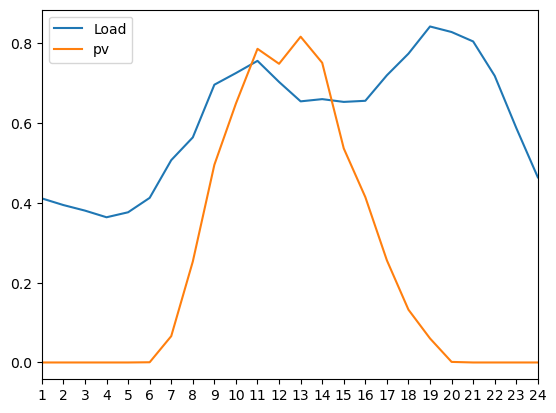

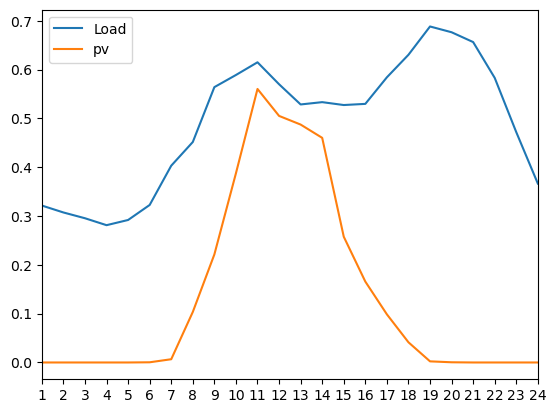

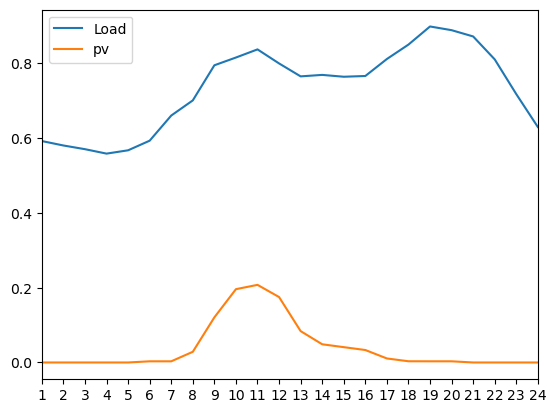

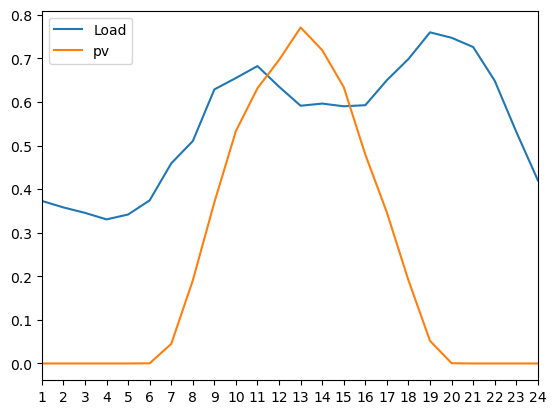

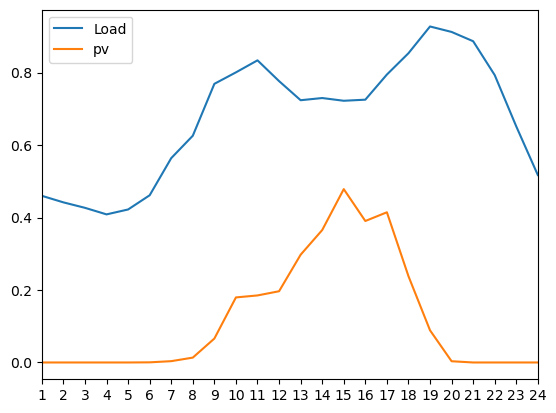

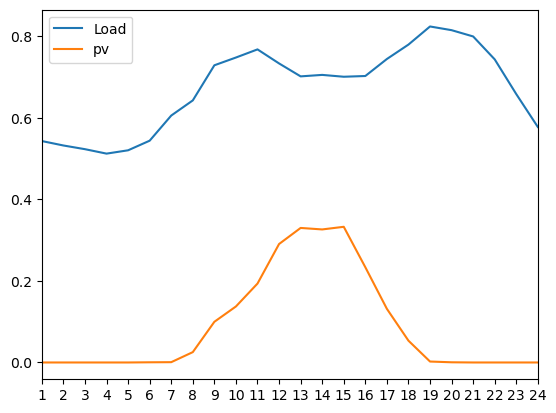

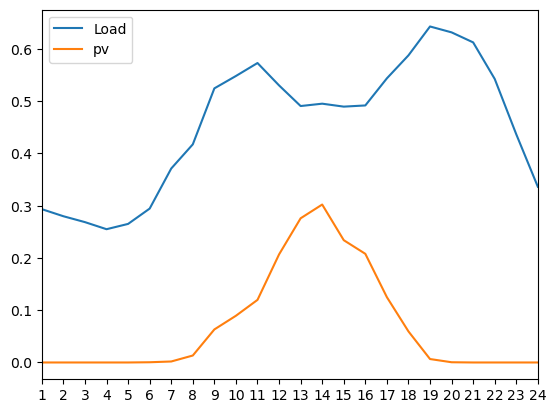

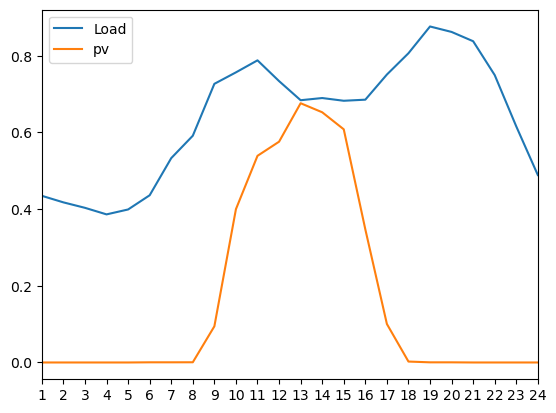

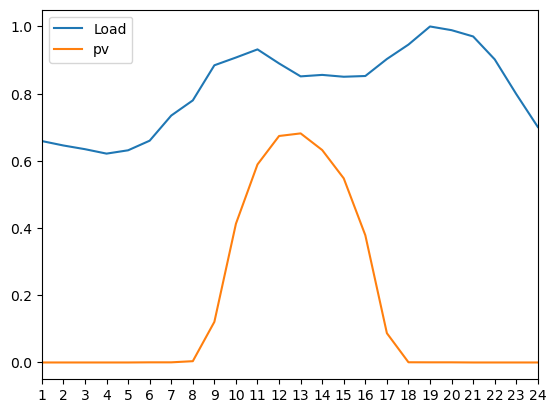

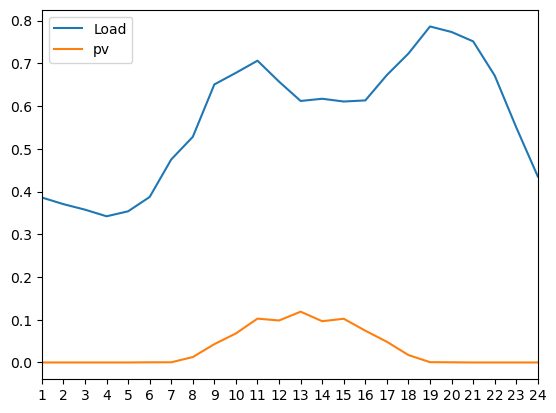

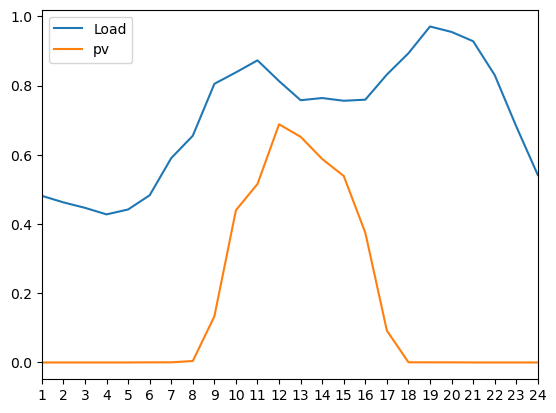

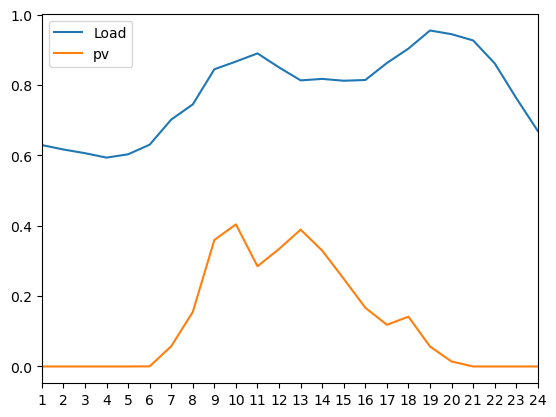

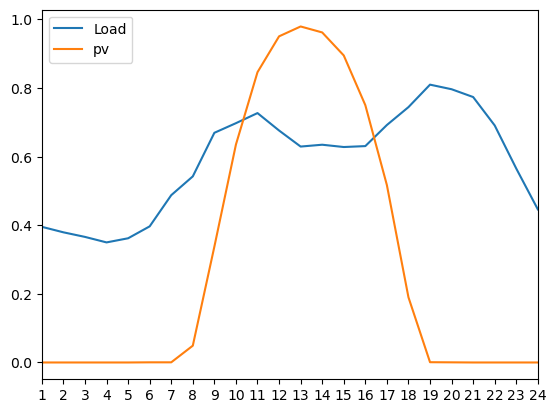

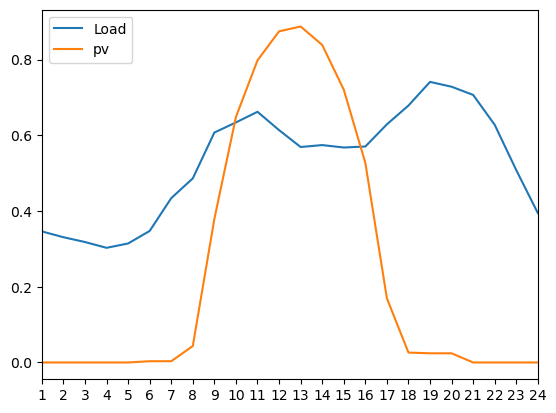

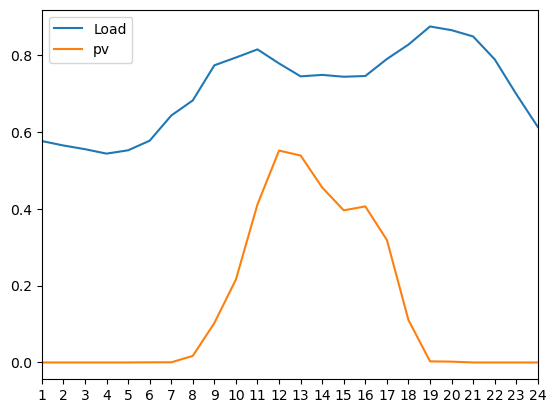

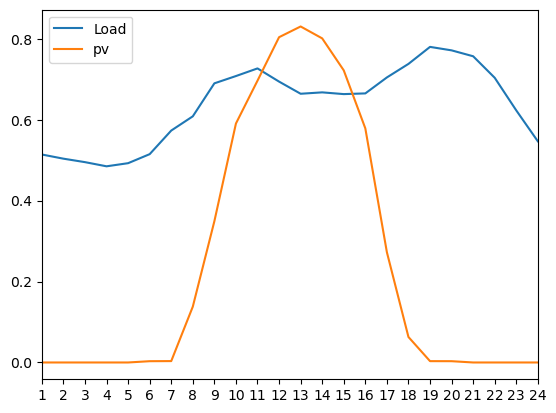

first_step: 8909746.673291396
first_step cap [5.5, array(11.81124177), array(2.), array(3.46176663), array(625.85999048)]
first_step cost [3575000.0, 1862479.1289010232, 0.0, 1457592.3617486346, 1299236.5943612955, 0.0, 200000.00000000006, 18664.793494555553, 496773.7947860897]
freq_nadir: {0: array([[-0.49993653, -0.49993659, -0.49993663, -0.49993668, -0.49993664,
        -0.49993653, -0.49846798, -0.49846025, -0.79120752, -0.77853205,
        -0.76644313, -0.78808358, -0.49805077, -0.80865058, -0.81239869,
        -0.66957228, -0.56474472, -0.50438609, -0.57603794, -0.61134438,
        -0.60218506, -0.5641244 , -0.50717406, -0.49993633],
       [-0.62031153, -0.65722723, -0.61129364, -0.63341557, -0.60394885,
        -0.67080004, -0.73116917, -0.73662775, -0.85154912, -0.85097289,
        -0.83405979, -0.85529224, -0.82277927, -0.83014205, -0.78607193,
        -0.82903205, -0.85430002, -0.52483244, -0.55053423, -0.5452532 ,
        -0.53629375, -0.50529066, -0.78894282, -0.70796705],

In [39]:
start = time.time()
# df_load = pd.read_csv("data/day_load.csv", header=None)
# load = df_load.values
# cluster_load = cluster_net_load(10*load)
# cluster_load.get_cluster()
# print('cluster finished')
file_list = ["data/day_load.csv", "data/day_pv.csv",
             "data/cluster_day.csv", "data/period.csv"]
data = read_data(file_list)
day_load, day_pv, cluster_day_num, period = data.get_data()
# df_day_load = pd.read_csv("data/load_day_data_cluster4.csv", header=None)
# day_load = df_day_load.values
# df_day_pv = pd.read_csv("data/pv_day_data_cluster4.csv", header=None)
# day_pv = df_day_pv.values
# df_cluster_day_num = pd.read_csv("data/cluster_day.csv", header=None)
# cluster_day_num = df_cluster_day_num.values[1]
# df_period = pd.read_csv("data/period.csv", header=None)
# period = df_period.values
day_num = day_load.shape[0]
# show cluster
for day_index in range(day_num):
        load_hour = day_load[day_index]
        pv_hour = day_pv[day_index]
        fig, axe = plt.subplots()
        x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
        labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
        axe.plot(x, load_hour, label="Load")
        axe.plot(x, pv_hour, label="pv")
        plt.xlim((1, 24))
        axe.set_xticks(x)
        axe.set_xticklabels(labels)
        axe.legend(loc='upper left')
        plt.show()
# first step
first_step = first_step_planning(day_load, day_pv, cluster_day_num, period)
(cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand,
cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, 
BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save,
freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, 
PV_inertia_response, BESS_inertia_response, SMR_damping_response) = first_step.get_initial_result()
print('first_step:', cost)
print('first_step cap', cap_com)
print('first_step cost', cost_com)
print('freq_nadir:', freq_nadir)
freq_iteration_process = freq_iteration(day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                 SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                 PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                 SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                 BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response)
(cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, 
SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, 
BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response) = freq_iteration_process.get_freq_ite_result()
PV_plan = {}
PV_plan[0] = cap_com[1]
print('overall cost:', cost)
print('cap_com:', cap_com)
print('cost_com:', cost_com)
cap_com_save_out = {}
SMR_output_save_out = {}
PV_output_save_out = {}
PV_output_cut_save_out = {}
BESS_charge_power_save_out = {}
BESS_discharge_power_save_out = {}
SESS_charge_power_save_out = {}
SESS_discharge_power_save_out = {}
cost_save_out = {}
cost_com_save_out = {}
freq_nadir_out = {}
SMR_droop_response_out = {}
PV_droop_response_out = {}
BESS_droop_response_out = {}
SMR_inertia_response_out = {}
PV_inertia_response_out = {}
BESS_inertia_response_out = {}
SMR_damping_response_out = {}
# save out0 variable
cap_com_save_out[0] = cap_com_save
SMR_output_save_out[0] = SMR_output_save
PV_output_save_out[0] = PV_output_save
PV_output_cut_save_out[0] = PV_output_cut_save
BESS_charge_power_save_out[0] = BESS_charge_power_save
BESS_discharge_power_save_out[0] = BESS_discharge_power_save
SESS_charge_power_save_out[0] = SESS_charge_power_save
SESS_discharge_power_save_out[0] = SESS_discharge_power_save
cost_save_out[0] = cost_save
cost_com_save_out[0] = cost_com_save
freq_nadir_out[0] = freq_nadir
SMR_droop_response_out[0] = SMR_droop_response
PV_droop_response_out[0] = PV_droop_response
BESS_droop_response_out[0] = BESS_droop_response
SMR_inertia_response_out[0] = SMR_inertia_response
PV_inertia_response_out[0] = PV_inertia_response
BESS_inertia_response_out[0] = BESS_inertia_response
SMR_damping_response_out[0] = SMR_damping_response
end = time.time()
print('Time used: ', end-start)

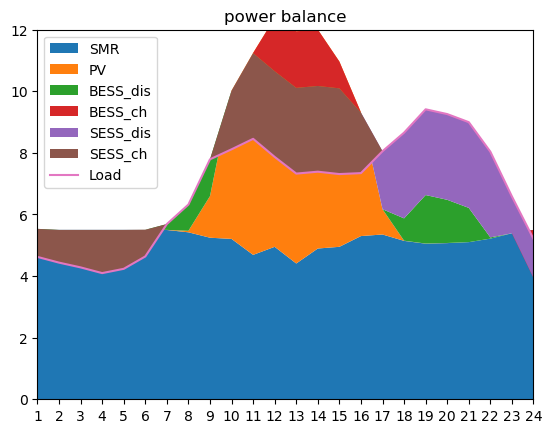

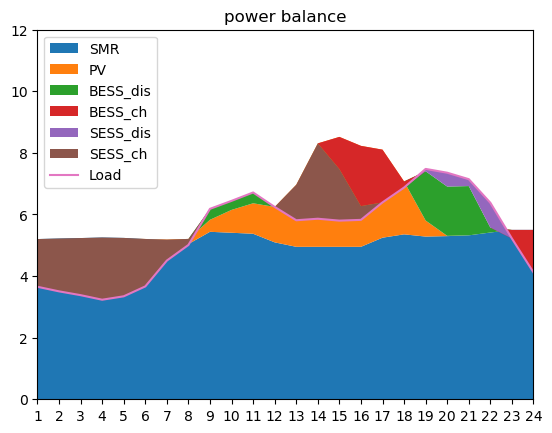

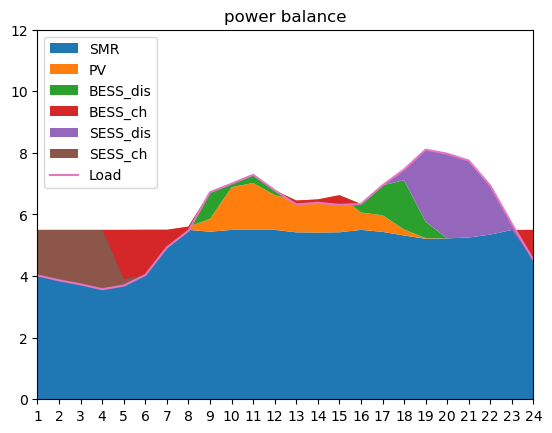

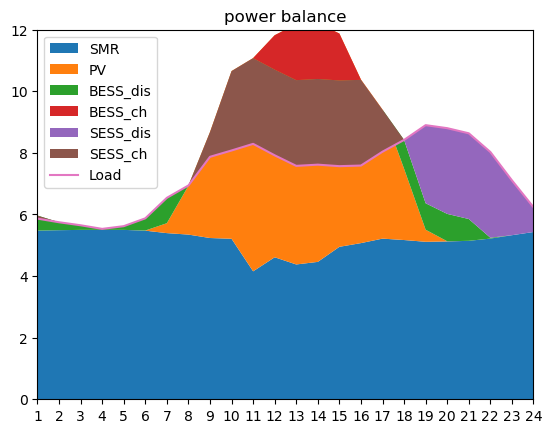

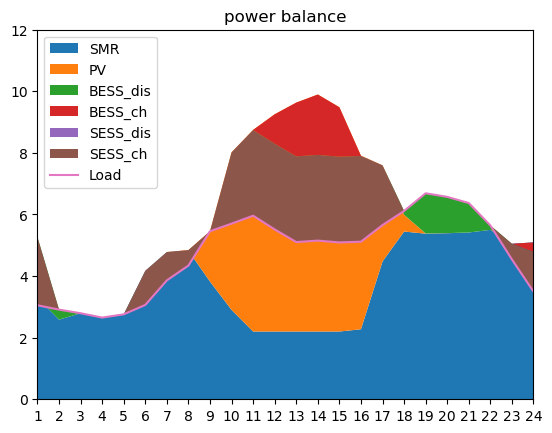

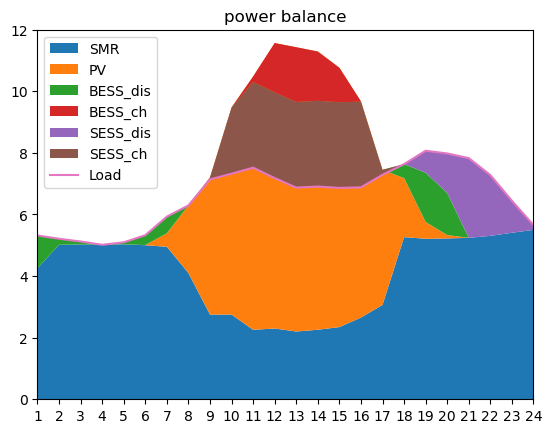

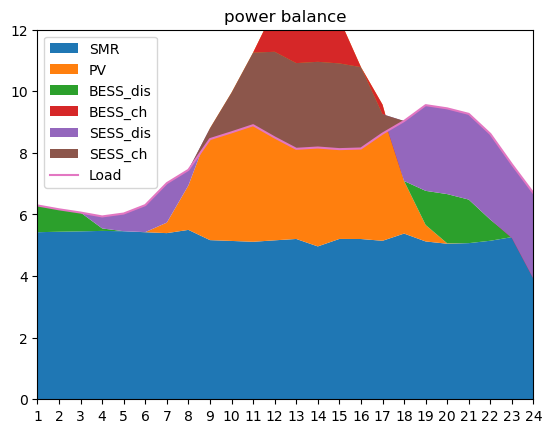

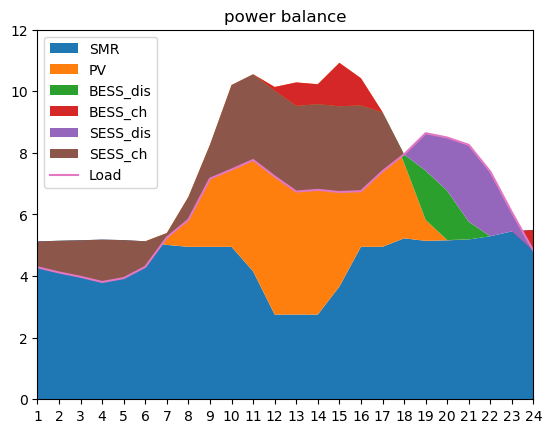

In [64]:
# show power balance result for each representative day
for day_index in range(day_num):
    SMR_p = SMR_output_save_out[0][0][day_index]
    PV_p = PV_output_save_out[0][0][day_index]
    BESS_pc = BESS_charge_power_save_out[0][0][day_index]
    BESS_pd = BESS_discharge_power_save_out[0][0][day_index]
    SESS_pc = SESS_charge_power_save_out[0][0][day_index]
    SESS_pd = SESS_discharge_power_save_out[0][0][day_index]
    load_hour = 10*day_load[day_index]
    y_SMR = SMR_p
    y_PV = PV_p
    y_BESS_pc = BESS_pc
    y_BESS_pd = BESS_pd
    y_SESS_pc = SESS_pc
    y_SESS_pd = SESS_pd
    fig, axe = plt.subplots()
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
    axe.stackplot(x, y_SMR, y_PV, y_BESS_pd, -y_BESS_pc, y_SESS_pd, -y_SESS_pc,
                  labels=["SMR", "PV", "BESS_dis", "BESS_ch", "SESS_dis", "SESS_ch"])
    axe.plot(x, load_hour, label="Load")
    plt.xlim((1, 24))
    plt.ylim((0, 12))
    axe.set_xticks(x)
    axe.set_xticklabels(labels)
    axe.set_title("power balance")
    axe.legend(loc='upper left')
    plt.show()

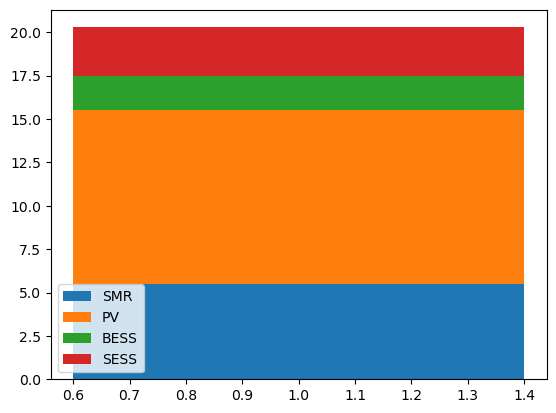

In [65]:
# capacity combination
SMR_capacity = cap_com_save_out[0][0][0]
PV_capacity = cap_com_save_out[0][0][1]
BESS_capacity = cap_com_save_out[0][0][2]
SESS_capcity = cap_com_save_out[0][0][3]
plt.bar(1, SMR_capacity, label='SMR')
plt.bar(1, PV_capacity, bottom=SMR_capacity, label='PV')
plt.bar(1, BESS_capacity, bottom=SMR_capacity+PV_capacity, label='BESS')
plt.bar(1, SESS_capcity, bottom=SMR_capacity+PV_capacity+BESS_capacity, label='SESS')
plt.legend()
plt.show()

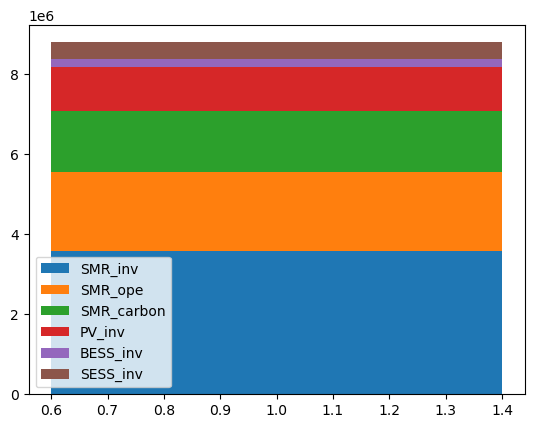

In [66]:
cost_com_save_out
# cost combination
SMR_inv_cost = cost_com_save_out[0][0][0]
SMR_ope_cost = cost_com_save_out[0][0][1]
SMR_carbon_cost = cost_com_save_out[0][0][3]
PV_inv_cost = cost_com_save_out[0][0][4]
BESS_inv_cost = cost_com_save_out[0][0][6]
SESS_inv_cost = cost_com_save_out[0][0][8]
plt.bar(1, SMR_inv_cost, label='SMR_inv')
plt.bar(1, SMR_ope_cost, bottom=SMR_inv_cost, label='SMR_ope')
plt.bar(1, SMR_carbon_cost, bottom=SMR_inv_cost+SMR_ope_cost, label='SMR_carbon')
plt.bar(1, PV_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost+SMR_carbon_cost, label='PV_inv')
plt.bar(1, BESS_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost+SMR_carbon_cost+PV_inv_cost, label='BESS_inv')
plt.bar(1, SESS_inv_cost, bottom=SMR_inv_cost+SMR_ope_cost+SMR_carbon_cost+PV_inv_cost+BESS_inv_cost, label='SESS_inv')
plt.legend()
plt.show()

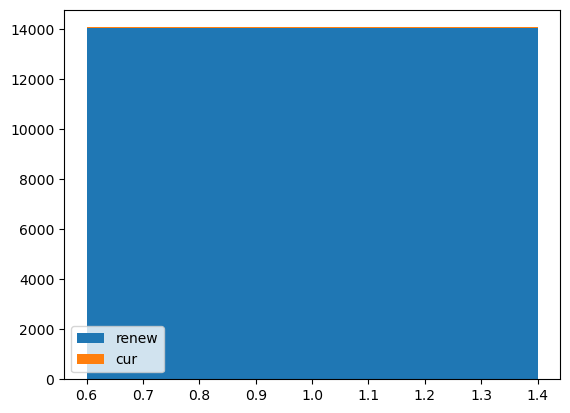

PV curtailment: 0.0027098329565325542


In [67]:
PV_output_save_out[0] = PV_output_save
PV_output_cut_save_out[0] = PV_output_cut_save
#  PV, wind curtailment
PV_power = 0
PV_cur = 0
PV_cur_vector = []
for day_index in range(day_num):
    day_index_num = cluster_day_num[day_index]
    P_PV = PV_output_save_out[0][0][day_index]*day_index_num
    P_PV_cur = PV_output_cut_save_out[0][0][day_index]*day_index_num
    PV_cur_vector.append(P_PV_cur)
    PV_power = PV_power + sum(P_PV)
    PV_cur = PV_cur + sum(P_PV_cur)
out = [PV_power]
cur = [PV_cur]
plt.bar(1, out, label='renew')
plt.bar(1, cur, bottom=out, label='cur')
# plt.xticks('PV')
plt.legend()
plt.show()
print('PV curtailment:', PV_cur/(PV_power+PV_cur))

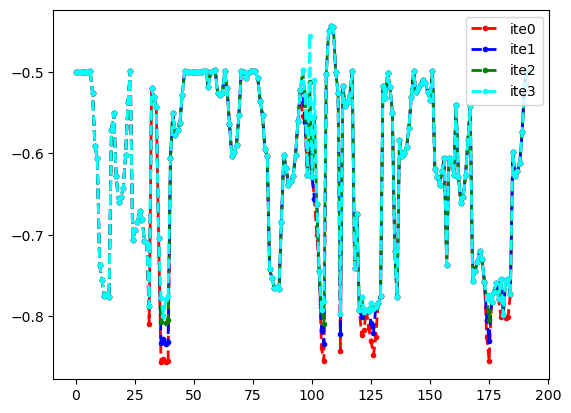

In [68]:
color_temp = ['red', 'blue', 'green', 'cyan', 'brown', 'magenta', 'yellow', 'gray', 'brown'] 
label_temp = ['ite0', 'ite1', 'ite2', 'ite3', 'ite4', 'ite5', 'ite6', 'ite7', 'ite8'] 
fig, ax = plt.subplots()
for temp in range(4):
    freq_value = freq_nadir_out[0][temp].flatten()
    ax.plot(freq_value, color=color_temp[temp], linestyle="dashed", linewidth=2, marker="o", markersize=3, label=label_temp[temp])
    ax.legend()
plt.show()

ite_out: 1
cluster finished


/home/hmy/miniconda3/envs/optim/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


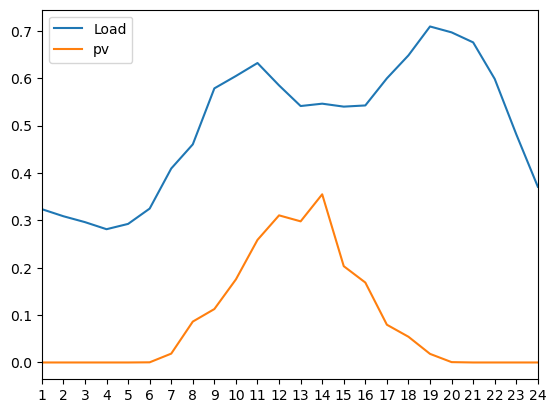

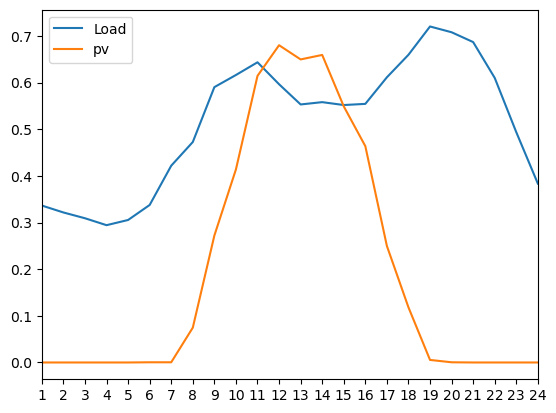

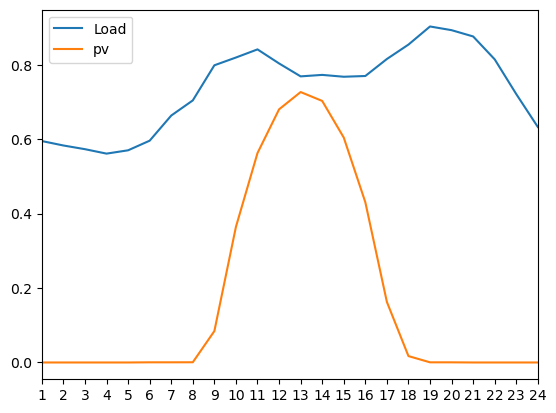

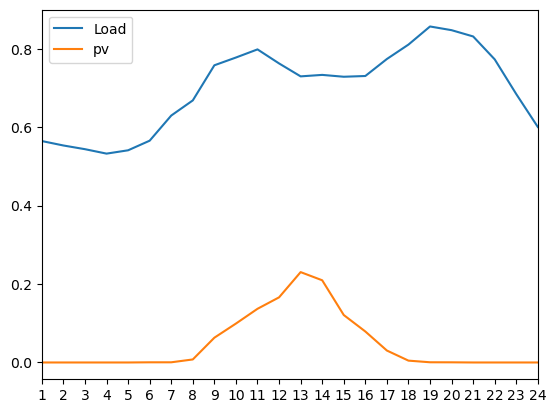

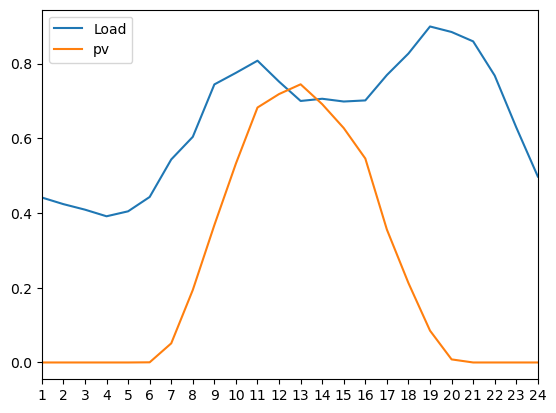

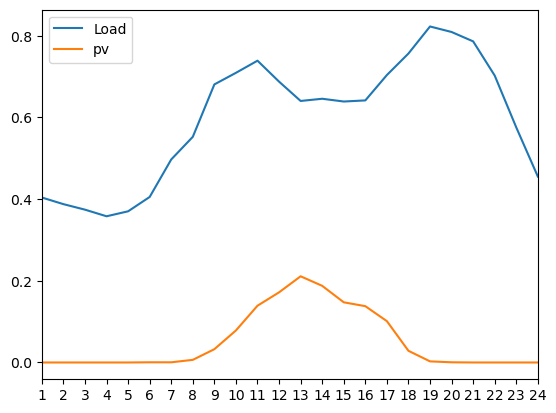

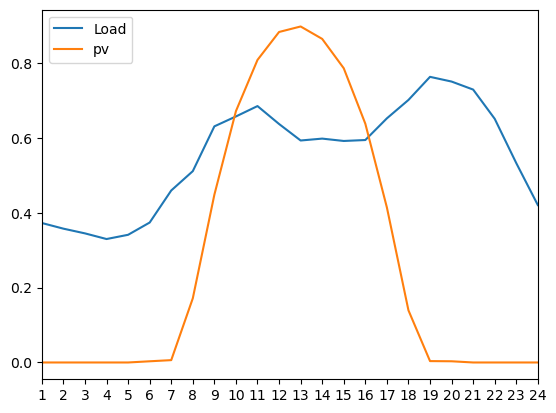

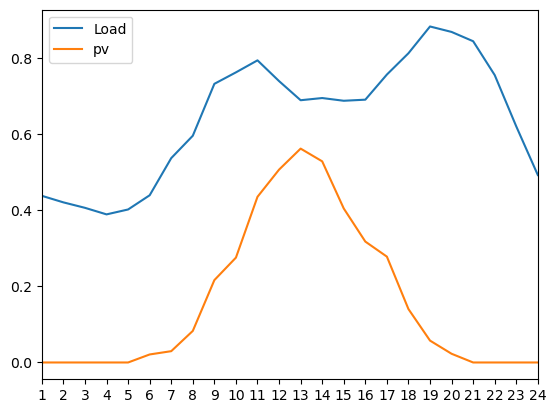

first_step: 8856070.315851033
first_step cap [5.5, array(10.), array(2.), array(2.43841775), array(1279.11586852)]
first_step cost [3575000.0, 1963448.1958688116, 0.0, 1536611.6315495048, 1100000.0, 0.0, 200000.00000000006, 22115.296101878677, 458895.1923307684]
freq_nadir: {0: array([[-0.67168831, -0.65852192, -0.64722684, -0.63075717, -0.60531436,
        -0.67224508, -0.74234627, -0.78073308, -0.85802697, -0.84055824,
        -0.82398481, -0.85374986, -0.83684351, -0.84012726, -0.83601467,
        -0.83766388, -0.63752843, -0.53277553, -0.5599641 , -0.55440414,
        -0.54495099, -0.51140915, -0.515047  , -0.50536697],
       [-0.49993675, -0.49993678, -0.49993681, -0.49993684, -0.49993681,
        -0.49993674, -0.4999365 , -0.4999363 , -0.50811772, -0.83312134,
        -0.81754214, -0.84572227, -0.84460345, -0.84780008, -0.84379834,
        -0.84540681, -0.51673116, -0.53780332, -0.56162061, -0.55913014,
        -0.54996169, -0.51620594, -0.49846956, -0.49993662],
       [-0.5099

/home/hmy/miniconda3/envs/optim/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


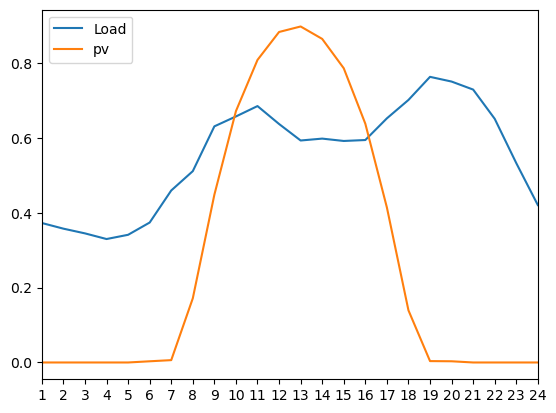

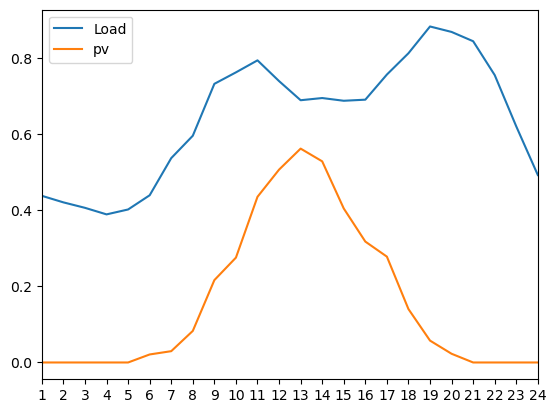

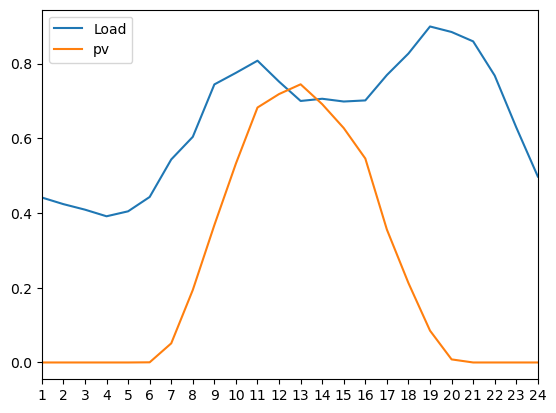

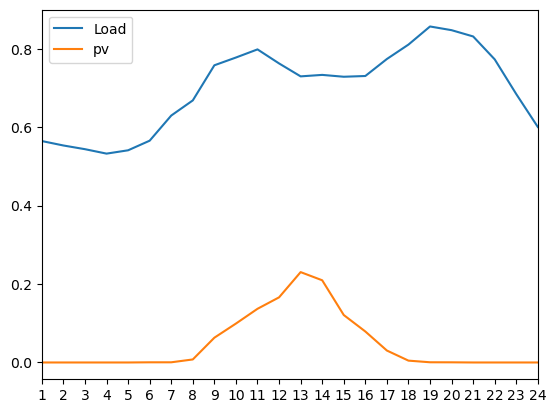

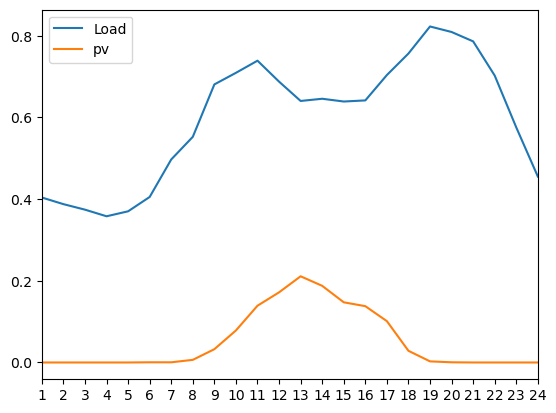

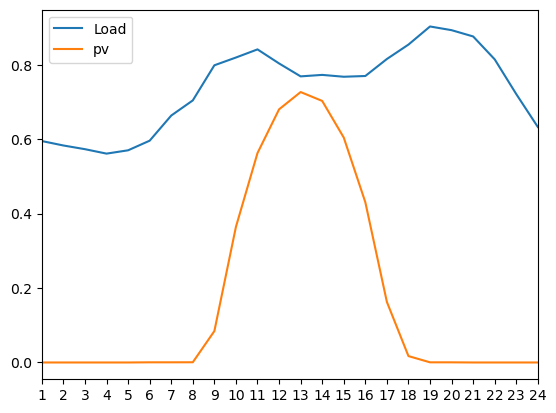

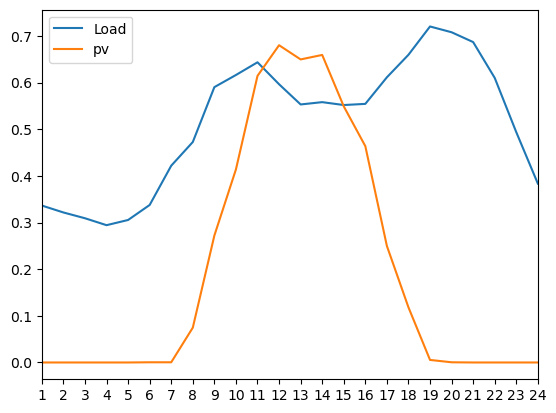

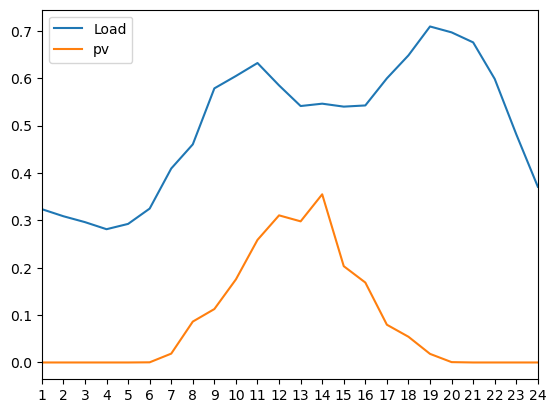

first_step: 8854068.86899198
first_step cap [5.5, array(10.), array(2.), array(2.43841775), array(1277.2490594)]
first_step cost [3575000.0, 1962471.0630263893, 0.0, 1535846.9188902243, 1100000.0, 0.0, 200000.00000000006, 22098.37992941374, 458652.5071459032]
freq_nadir: {0: array([[-0.71319276, -0.70085076, -0.68167844, -0.63682796, -0.68689382,
        -0.71424453, -0.7604134 , -0.79631683, -0.5252629 , -0.53423624,
        -0.50792523, -0.50426356, -0.50181279, -0.50116057, -0.50175749,
        -0.49994425, -0.81271521, -0.55662177, -0.58410348, -0.57852848,
        -0.56900133, -0.53413088, -0.49846472, -0.4999365 ],
       [-0.49993644, -0.4999365 , -0.49993655, -0.4999366 , -0.49993656,
        -0.49993643, -0.49846422, -0.51012736, -0.56994496, -0.58329984,
        -0.59716989, -0.57312885, -0.56202264, -0.55329308, -0.55008163,
        -0.55136344, -0.58076354, -0.5272409 , -0.60042322, -0.61501584,
        -0.61889533, -0.58013044, -0.52030876, -0.49846975],
       [-0.4999364

/home/hmy/miniconda3/envs/optim/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


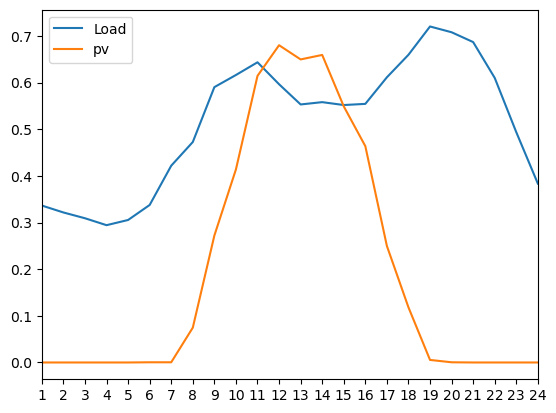

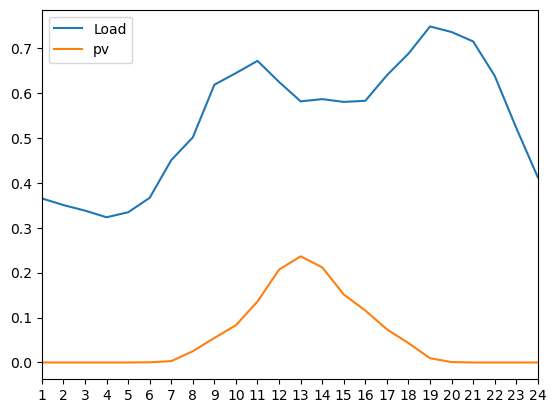

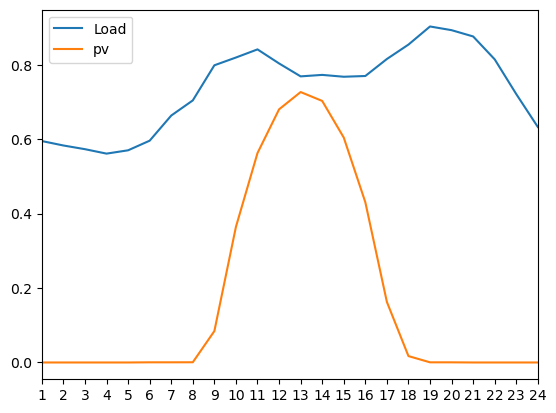

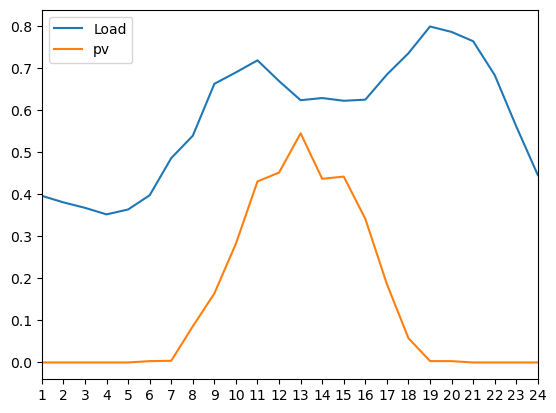

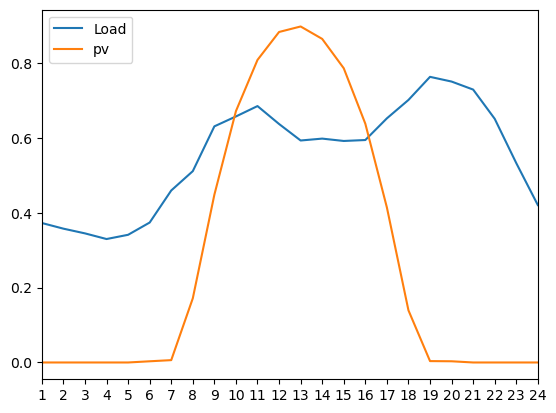

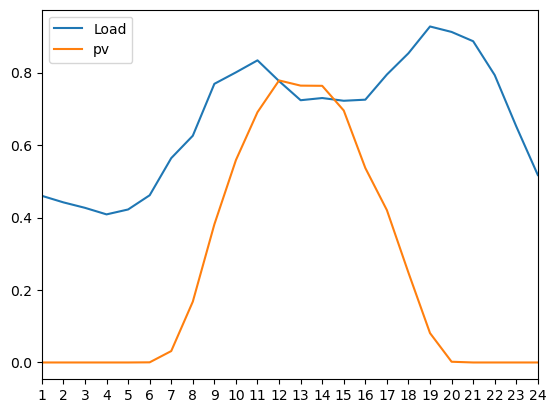

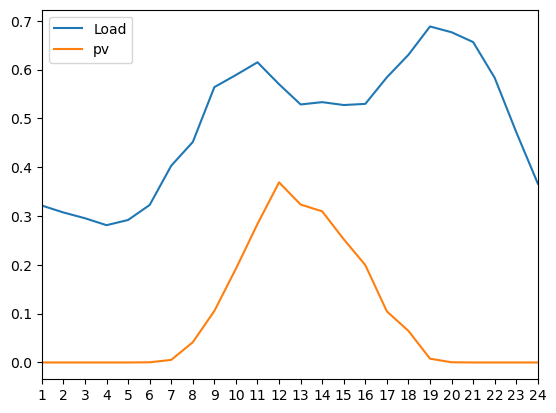

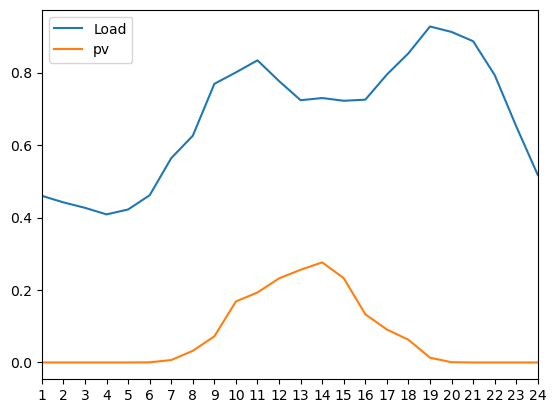

first_step: 8908205.161494818
first_step cap [6.0, array(10.), array(2.), array(1.95629891), array(1014.72550079)]
first_step cost [3900000.0, 1865369.558703369, 0.0, 1459854.4372461163, 1100000.0, 0.0, 200000.00000000006, 16310.981016006892, 366670.1845293472]
freq_nadir: {0: array([[-0.62482887, -0.65118383, -0.64070782, -0.62789785, -0.6375551 ,
        -0.66445691, -0.7299917 , -0.74300938, -0.83810348, -0.8575871 ,
        -0.52632652, -0.50752553, -0.72355427, -0.77187865, -0.81852485,
        -0.82011006, -0.8547295 , -0.8258814 , -0.55908219, -0.55376624,
        -0.54472724, -0.5127052 , -0.77610885, -0.60286311],
       [-0.67811878, -0.67486485, -0.66470917, -0.64308175, -0.6208182 ,
        -0.68042121, -0.70788244, -0.75162882, -0.6676592 , -0.67815268,
        -0.83373927, -0.86230404, -0.83565295, -0.83978084, -0.83603531,
        -0.8375394 , -0.65225958, -0.54490544, -0.57085955, -0.56556235,
        -0.55657433, -0.52398333, -0.66060953, -0.53434407],
       [-0.50696

/home/hmy/miniconda3/envs/optim/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


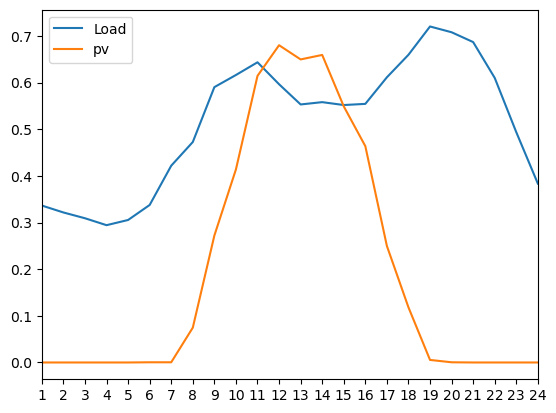

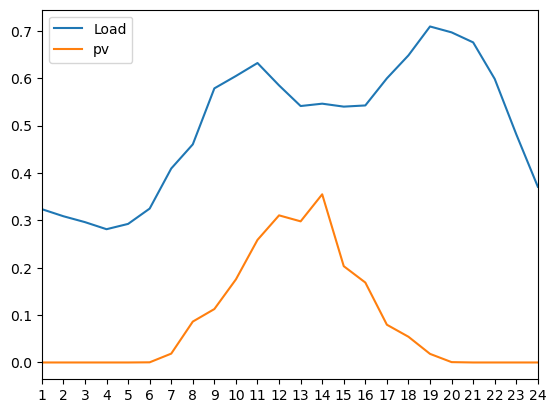

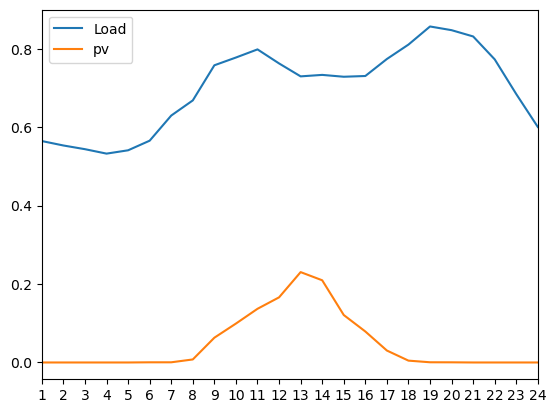

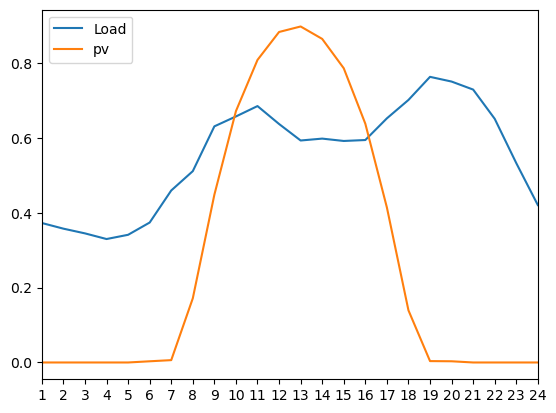

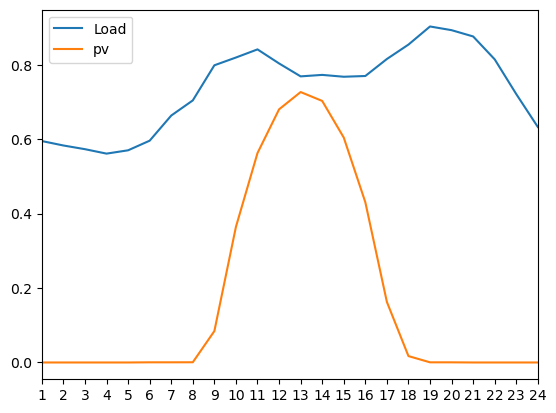

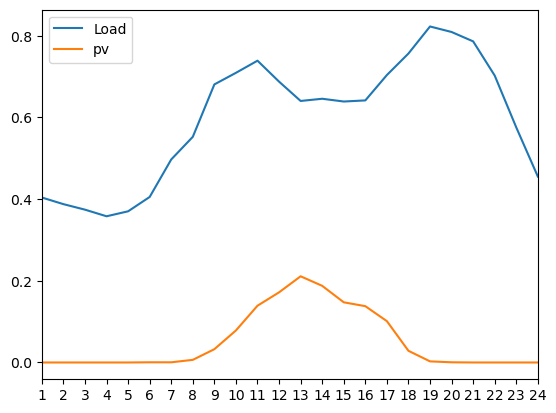

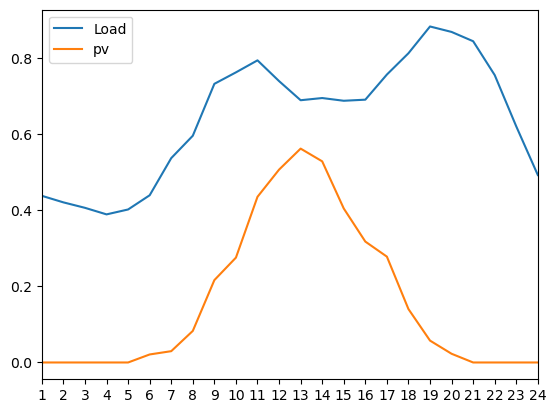

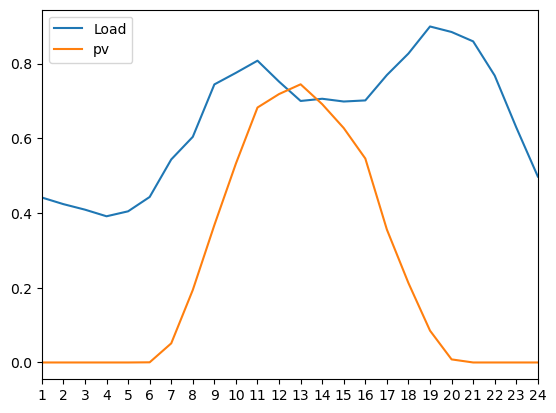

first_step: 8854749.26254936
first_step cap [5.5, array(10.), array(2.), array(2.43841775), array(1269.88316299)]
first_step cost [3575000.0, 1963431.644974729, 0.0, 1536598.6786758776, 1100000.0, 0.0, 200000.00000000006, 22023.99828656122, 457694.9406120264]
freq_nadir: {0: array([[-0.49993675, -0.49993678, -0.49993681, -0.49993684, -0.49993681,
        -0.49993674, -0.4999365 , -0.4999363 , -0.50811772, -0.83312134,
        -0.81754214, -0.84572227, -0.84460345, -0.84780008, -0.82278281,
        -0.84540681, -0.51673116, -0.53780332, -0.56162061, -0.55913014,
        -0.54996169, -0.51620594, -0.49846956, -0.49993662],
       [-0.67168831, -0.65852192, -0.64722684, -0.63075717, -0.60531436,
        -0.67224508, -0.70251815, -0.78073308, -0.85802697, -0.84055824,
        -0.82398481, -0.85374986, -0.83684351, -0.84012726, -0.83601467,
        -0.83766388, -0.63752843, -0.53277553, -0.5599641 , -0.55440414,
        -0.54495099, -0.51140915, -0.515047  , -0.50536697],
       [-0.4984601

/home/hmy/miniconda3/envs/optim/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


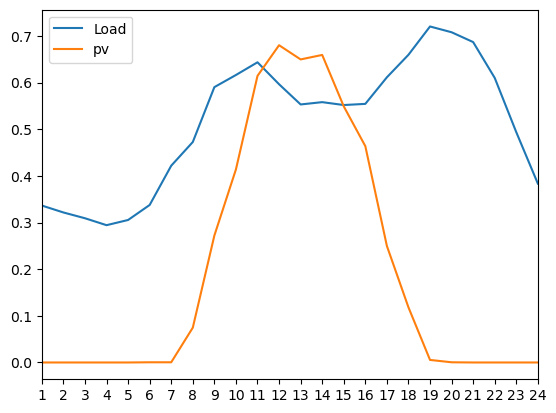

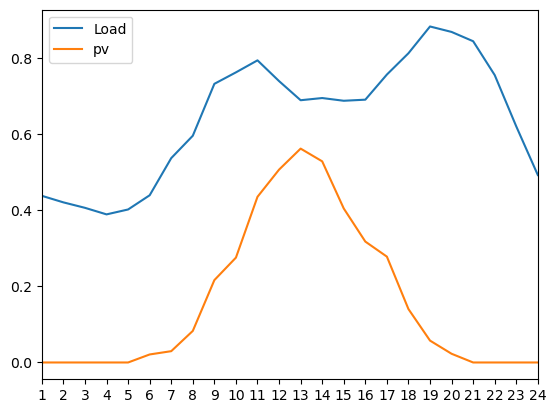

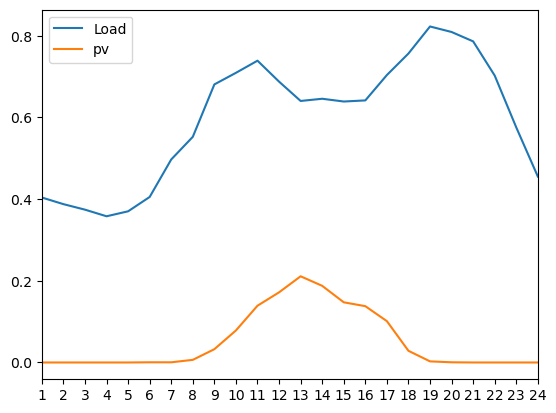

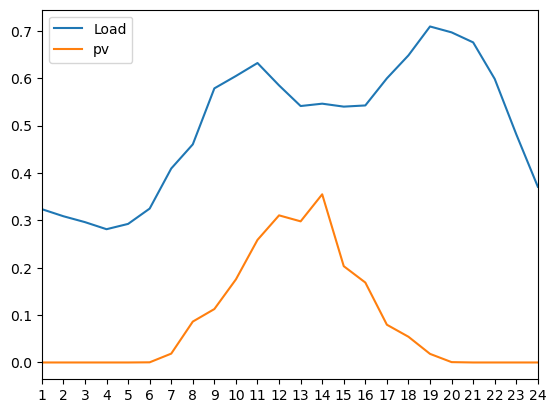

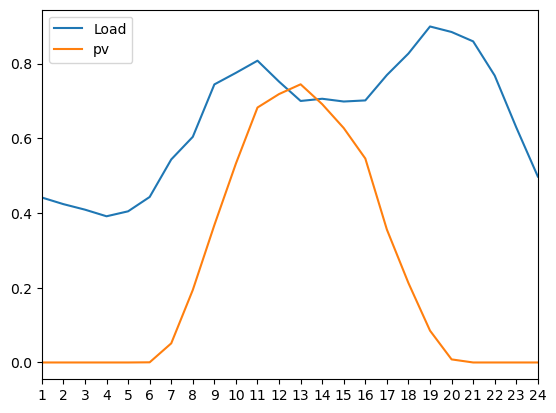

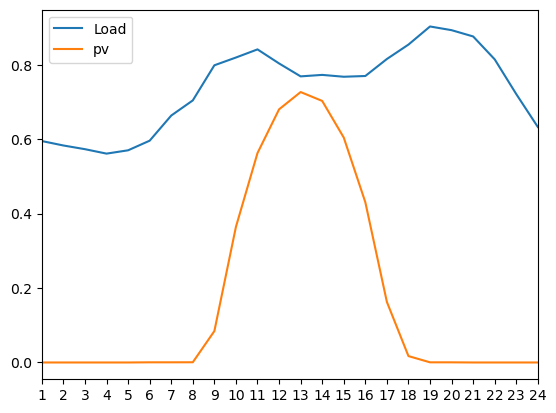

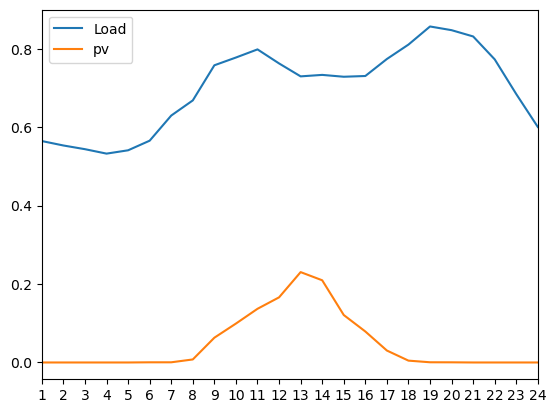

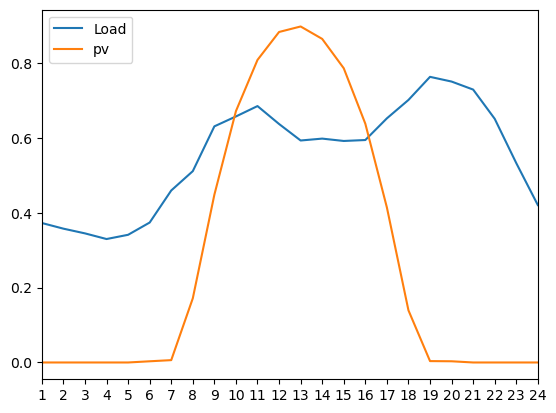

first_step: 8855328.850057602
first_step cap [5.5, array(10.), array(2.), array(2.43841775), array(1274.41807125)]
first_step cost [3575000.0, 1963381.327899296, 0.0, 1536559.300095096, 1100000.0, 0.0, 200000.00000000006, 22103.743376867995, 458284.47868625337]
freq_nadir: {0: array([[-0.49993675, -0.49993678, -0.49993681, -0.49993684, -0.49993681,
        -0.49993674, -0.4999365 , -0.4999363 , -0.50811772, -0.83312134,
        -0.81754214, -0.84572227, -0.84460345, -0.84780008, -0.84379834,
        -0.84540681, -0.51673116, -0.53780332, -0.56162061, -0.55913014,
        -0.54996169, -0.51620594, -0.49846956, -0.49993662],
       [-0.49993644, -0.4999365 , -0.49993655, -0.4999366 , -0.49993656,
        -0.49993643, -0.49846422, -0.51012736, -0.56994496, -0.58329984,
        -0.59716989, -0.57312885, -0.56202264, -0.55329308, -0.55008163,
        -0.55136344, -0.58076354, -0.5272409 , -0.60042322, -0.61501584,
        -0.61889533, -0.58013044, -0.52030876, -0.49846975],
       [-0.49993

KeyboardInterrupt: 

In [69]:
ite_out = 0
while ite_out<20:
    start = time.time()
    ite_out = ite_out + 1
    print('ite_out:', ite_out)
    df_load = pd.read_csv("data/day_load.csv", header=None)
    df_pv = pd.read_csv("data/day_pv.csv", header=None)
    load = df_load.values
    pv_ratio = df_pv.values
    load_level = 10
    PV_level = PV_plan[ite_out-1]
    net_load = load_level*load - PV_level*pv_ratio
    cluster_load = cluster_net_load(net_load)
    cluster_load.get_cluster()
    print('cluster finished')
    file_list = ["data/day_load.csv", "data/day_pv.csv",
                 "data/cluster_day.csv", "data/period.csv"]
    data = read_data(file_list)
    day_load, day_pv, cluster_day_num, period = data.get_data()
    day_num = day_load.shape[0]
    # show cluster
    for day_index in range(day_num):
            load_hour = day_load[day_index]
            pv_hour = day_pv[day_index]
            fig, axe = plt.subplots()
            x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                     11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                     21, 22, 23, 24])
            labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
                  "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
            axe.plot(x, load_hour, label="Load")
            axe.plot(x, pv_hour, label="pv")
            plt.xlim((1, 24))
            axe.set_xticks(x)
            axe.set_xticklabels(labels)
            axe.legend(loc='upper left')
            plt.show()
        # first step
    # first step
    first_step = first_step_planning(day_load, day_pv, cluster_day_num, period)
    (cost, cap_com, cost_com, f_max, mask, H_inertia, D, SMR_droop, PV_droop, BESS_droop, fast_droop_expand,
    cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, 
    BESS_discharge_power_save, SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save,
    freq_nadir, SMR_droop_response, PV_droop_response, BESS_droop_response, SMR_inertia_response, 
    PV_inertia_response, BESS_inertia_response, SMR_damping_response) = first_step.get_initial_result()
    print('first_step:', cost)
    print('first_step cap', cap_com)
    print('first_step cost', cost_com)
    print('freq_nadir:', freq_nadir)
    freq_iteration_process = freq_iteration(day_load, day_pv, cluster_day_num, period, cost, cap_com, cost_com, f_max, mask, H_inertia, D, 
                     SMR_droop, PV_droop, BESS_droop, fast_droop_expand, cap_com_save, SMR_output_save, PV_output_save, 
                     PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, SESS_charge_power_save, 
                     SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response,
                     BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response)
    (cost, cap_com, cost_com, cap_com_save, SMR_output_save, PV_output_save, PV_output_cut_save, BESS_charge_power_save, BESS_discharge_power_save, 
    SESS_charge_power_save, SESS_discharge_power_save, cost_save, cost_com_save, freq_nadir, SMR_droop_response, PV_droop_response, 
    BESS_droop_response, SMR_inertia_response, PV_inertia_response, BESS_inertia_response, SMR_damping_response) = freq_iteration_process.get_freq_ite_result()
    PV_plan[ite_out] = cap_com[1]
    print('overall cost:', cost)
    print('cap_com:', cap_com)
    print('cost_com:', cost_com)
    # save out0 variable
    cap_com_save_out[ite_out] = cap_com_save
    SMR_output_save_out[ite_out] = SMR_output_save
    PV_output_save_out[ite_out] = PV_output_save
    PV_output_cut_save_out[ite_out] = PV_output_cut_save
    BESS_charge_power_save_out[ite_out] = BESS_charge_power_save
    BESS_discharge_power_save_out[ite_out] = BESS_discharge_power_save
    SESS_charge_power_save_out[ite_out] = SESS_charge_power_save
    SESS_discharge_power_save_out[ite_out] = SESS_discharge_power_save
    cost_save_out[ite_out] = cost_save
    cost_com_save_out[ite_out] = cost_com_save
    freq_nadir_out[ite_out] = freq_nadir
    SMR_droop_response_out[ite_out] = SMR_droop_response
    PV_droop_response_out[ite_out] = PV_droop_response
    BESS_droop_response_out[ite_out] = BESS_droop_response
    SMR_inertia_response_out[ite_out] = SMR_inertia_response
    PV_inertia_response_out[ite_out] = PV_inertia_response
    BESS_inertia_response_out[ite_out] = BESS_inertia_response
    SMR_damping_response_out[ite_out] = SMR_damping_response
    end = time.time()
    print('Time used: ', end-start)

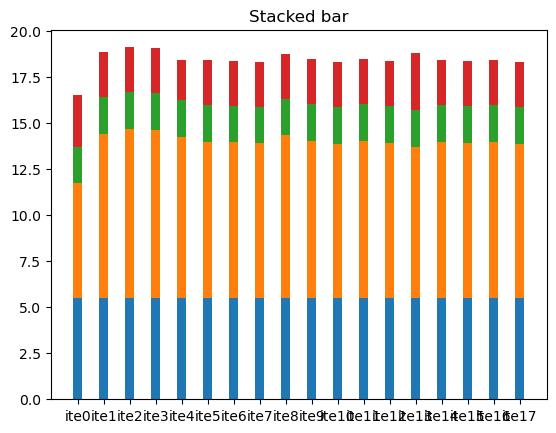

In [98]:
SMR_inv_vector = []
PV_inv_vector = []
BESS_inv_vector = []
SESS_inv_vector = []
for ite_out in range(18):
    temp = len(cap_com_save_out[ite_out])
    SMR_inv_vector.append(cap_com_save_out[ite_out][temp-1][0])
    PV_inv_vector.append(cap_com_save_out[ite_out][temp-1][1])
    BESS_inv_vector.append(cap_com_save_out[ite_out][temp-1][2])
    SESS_inv_vector.append(cap_com_save_out[ite_out][temp-1][3])
SMR_inv_vector = np.array(SMR_inv_vector)
PV_inv_vector = np.array(PV_inv_vector)
BESS_inv_vector = np.array(BESS_inv_vector)
SESS_inv_vector = np.array(SESS_inv_vector)
labels = ['ite0', 'ite1', 'ite2', 'ite3', 'ite4', 'ite5', 'ite6', 'ite7', 'ite8', 'ite9', 'ite10', 'ite11', 'ite12',
          'ite13', 'ite14', 'ite15', 'ite16', 'ite17']
width = 0.35  
plt.bar(labels, SMR_inv_vector, width)
plt.bar(labels, PV_inv_vector, width, bottom=SMR_inv_vector)
plt.bar(labels, BESS_inv_vector, width, bottom=SMR_inv_vector+PV_inv_vector)
plt.bar(labels, SESS_inv_vector, width, bottom=SMR_inv_vector+PV_inv_vector+BESS_inv_vector)
plt.title('Stacked bar')
# plt.ylim((1.075e8, 1.082e8))
plt.show()

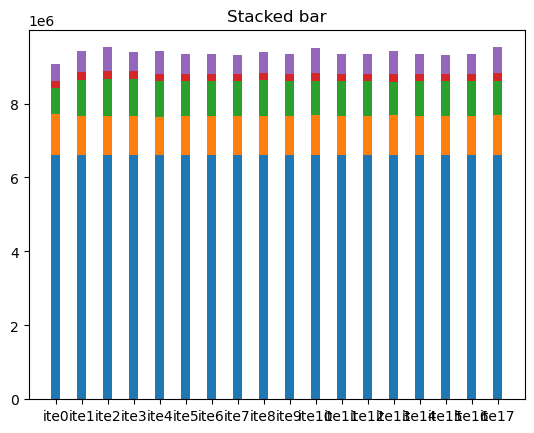

In [99]:
SMR_inv_vector = []
SMR_ope_vector = []
SMR_re_vector = []
PV_inv_vector = []
BESS_inv_vector = []
BESS_RE_vector = []
SESS_inv_vector = []
for ite_out in range(18):
    temp = len(cost_com_save_out[ite_out])
    SMR_inv_vector.append(cost_com_save_out[ite_out][temp-1][0])
    SMR_ope_vector.append(cost_com_save_out[ite_out][temp-1][1])
    # SMR_re_vector.append(cost_com[ite][2])
    PV_inv_vector.append(cost_com_save_out[ite_out][temp-1][3])
    BESS_inv_vector.append(cost_com_save_out[ite_out][temp-1][5])
    # BESS_RE_vector.append(cost_com[ite][5])
    SESS_inv_vector.append(cost_com_save_out[ite_out][temp-1][7])
SMR_inv_vector = np.array(SMR_inv_vector)
SMR_ope_vector = np.array(SMR_ope_vector)
# SMR_re_vector = np.array(SMR_re_vector)
PV_inv_vector = np.array(PV_inv_vector)
BESS_inv_vector = np.array(BESS_inv_vector)
# BESS_RE_vector = np.array(BESS_RE_vector)
SESS_inv_vector = np.array(SESS_inv_vector)
labels = ['ite0', 'ite1', 'ite2', 'ite3', 'ite4', 'ite5', 'ite6', 'ite7', 'ite8', 'ite9', 'ite10', 'ite11', 'ite12',
          'ite13', 'ite14', 'ite15', 'ite16', 'ite17']
width = 0.35  
plt.bar(labels, SMR_inv_vector, width)
plt.bar(labels, SMR_ope_vector, width, bottom=SMR_inv_vector)
# plt.bar(labels, SMR_re_vector, width, bottom=SMR_inv_vector+SMR_ope_vector)
plt.bar(labels, PV_inv_vector, width, bottom=SMR_inv_vector+SMR_ope_vector)
plt.bar(labels, BESS_inv_vector, width, bottom=SMR_inv_vector+SMR_ope_vector+PV_inv_vector)
# plt.bar(labels, BESS_RE_vector, width, bottom=SMR_inv_vector+SMR_ope_vector+SMR_re_vector+PV_inv_vector+BESS_inv_vector)
plt.bar(labels, SESS_inv_vector, width, bottom=SMR_inv_vector+SMR_ope_vector+PV_inv_vector+BESS_inv_vector)
plt.title('Stacked bar')
# plt.ylim((1.075e8, 1.082e8))
plt.show()

In [104]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [105]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [123]:
power_balance = {}
power_balance[0] = SMR_output_save_out[6][3]
power_balance[1] = PV_output_save_out[6][3]
power_balance[2] = BESS_charge_power_save_out[6][3]
power_balance[3] = BESS_discharge_power_save_out[6][3]
power_balance[4] = SESS_charge_power_save_out[6][3]
power_balance[5] = SESS_discharge_power_save_out[6][3]
# power_balance[6] = 10*day_load
import pickle
# open a file to save the dictionary
with open('result/power_balance_cluster8.pickle', 'wb') as handle:
    pickle.dump(power_balance, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/power_balance_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

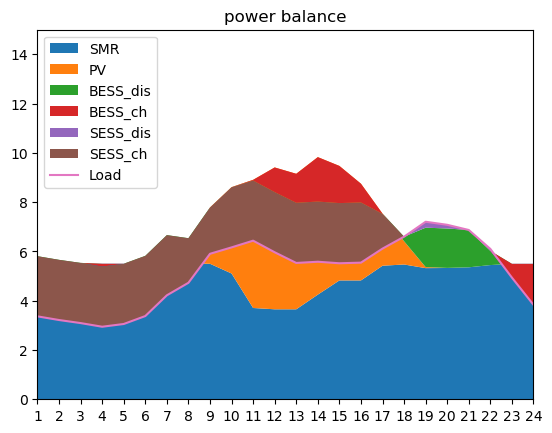

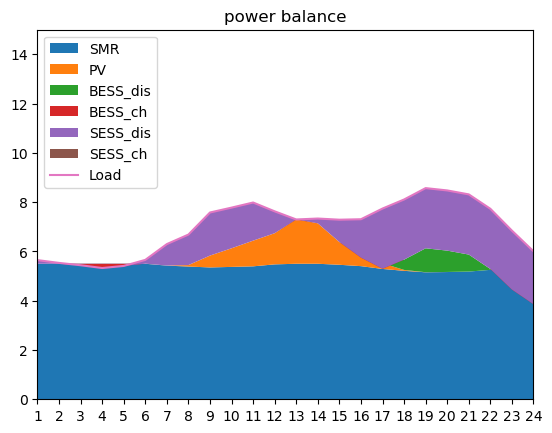

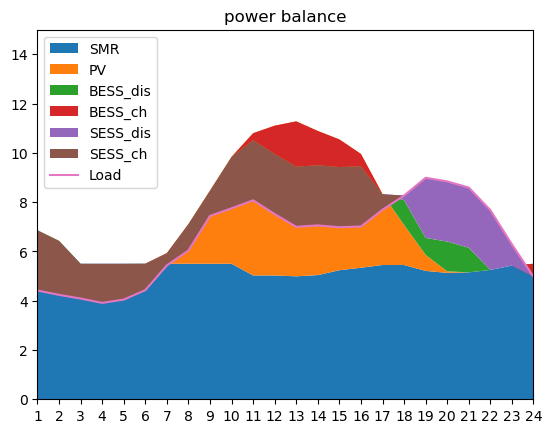

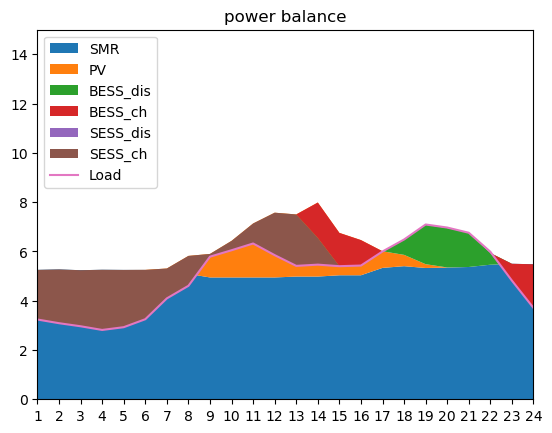

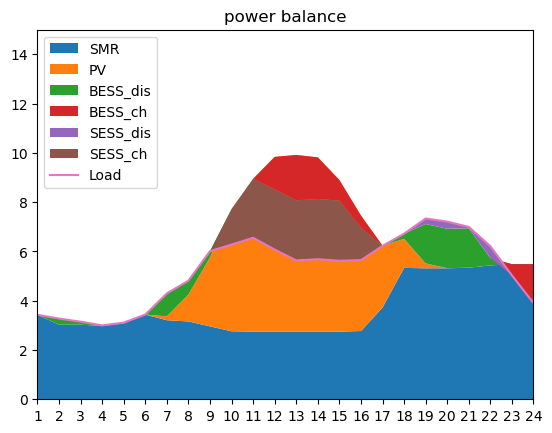

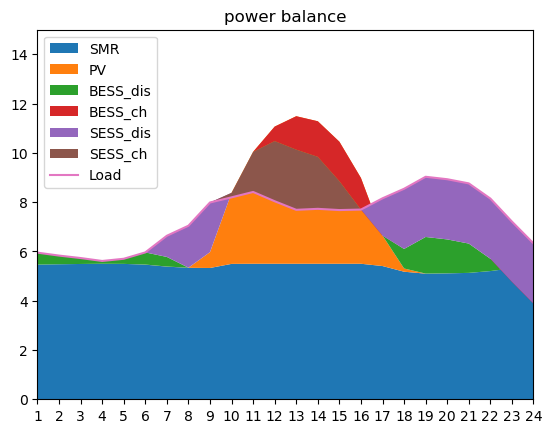

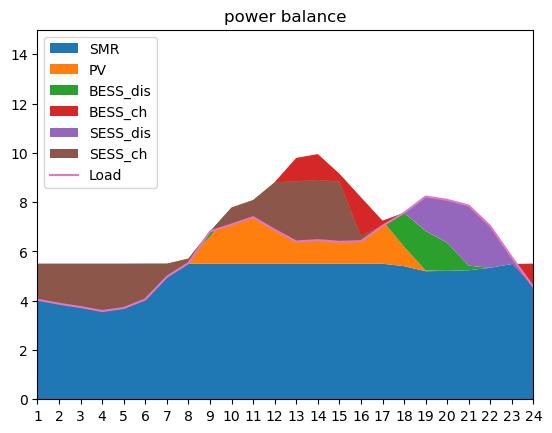

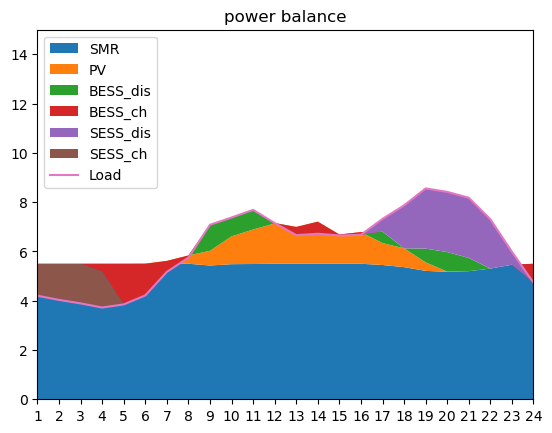

In [121]:
# show power balance result for each representative day
for day_index in range(day_num):
    SMR_p = SMR_output_save_out[6][3][day_index]
    PV_p = PV_output_save_out[6][3][day_index]
    BESS_pc = BESS_charge_power_save_out[6][3][day_index]
    BESS_pd = BESS_discharge_power_save_out[6][3][day_index]
    SESS_pc = SESS_charge_power_save_out[6][3][day_index]
    SESS_pd = SESS_discharge_power_save_out[6][3][day_index]
    # print('power:',SMR_p+PV_p+BESS_pd+SESS_pd)
    load_hour = SMR_p + PV_p + BESS_pd - BESS_pc + SESS_pd - SESS_pc;
    # print('out:',BESS_pc+SESS_pc+load_hour)
    y_SMR = SMR_p
    y_PV = PV_p
    y_BESS_pc = BESS_pc
    y_BESS_pd = BESS_pd
    y_SESS_pc = SESS_pc
    y_SESS_pd = SESS_pd
    fig, axe = plt.subplots()
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24])
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
              "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"]
    axe.stackplot(x, y_SMR, y_PV, y_BESS_pd, -y_BESS_pc, y_SESS_pd, -y_SESS_pc,
                  labels=["SMR", "PV", "BESS_dis", "BESS_ch", "SESS_dis", "SESS_ch"])
    axe.plot(x, load_hour, label="Load")
    plt.xlim((1, 24))
    plt.ylim((0, 15))
    axe.set_xticks(x)
    axe.set_xticklabels(labels)
    axe.set_title("power balance")
    axe.legend(loc='upper left')
    plt.show()

In [108]:
import pickle
# open a file to save the dictionary
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cap_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cap_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [109]:
import pickle
# open a file to save the dictionary
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(cost_com_save_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/cost_com_save_out_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [110]:
import pickle
# open a file to save the dictionary
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_nadir, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_ite_final_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [112]:
freq_response = {}
freq_response[0] = 2*4.5*55/50
freq_response[1] = 0.6*55/50
freq_response[2] = SMR_droop
freq_response[3] = PV_droop
freq_response[4] = BESS_droop
freq_response[5] = 0.05*10*day_load
import pickle
# open a file to save the dictionary
with open('result/freq_response_variable_reserve_cluster8.pickle', 'wb') as handle:
    pickle.dump(freq_response, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('result/freq_response_variable_reserve_cluster8.pickle', 'rb') as handle:
    my_test = pickle.load(handle)

In [113]:
my_test

{0: 9.9,
 1: 0.66,
 2: array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.5625    , 0.58104244, 0.58104244, 0.64354244, 0.64354244,
         0.58104244, 0.08343796, 0.20843796, 0.39593796, 0.37597824,
         0.34237313, 0.21737313, 0.02747761, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.03086381, 0.17237723, 0.04591734,
         0.05047556, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.17667964, 0.31565382, 0.51511036, 0.51509146,
         0.47813433, 0.33865672, 0.12720896, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.11408933, 0.36848353, 0.40950883,
         0.41440299, 0.28165672, 0

In [116]:
load_day_data = pd.DataFrame(day_load)
load_day_data.to_csv('result/load_day_data_cluster4.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [117]:
pv_day_data = pd.DataFrame(day_pv)
pv_day_data.to_csv('result/pv_day_data_cluster4.csv', sep= ',', encoding='utf-8', header=False, index=False)

In [118]:
cap_com_save_out

{0: {0: [5.5,
   array(6.23518832),
   array(2.),
   array(2.78826714),
   array(903.67722591)],
  1: [5.5,
   array(6.24232507),
   array(2.),
   array(2.78825781),
   array(902.62300404)],
  2: [5.5,
   array(6.23518832),
   array(2.),
   array(2.78826714),
   array(903.67584543)]},
 1: {0: [5.5,
   array(8.921782),
   array(2.),
   array(2.46246292),
   array(2262.98844779)],
  1: [5.5,
   array(8.921782),
   array(2.),
   array(2.46246235),
   array(2263.24664166)],
  2: [5.5,
   array(8.921782),
   array(2.),
   array(2.46246286),
   array(2266.14307118)],
  3: [5.5,
   array(8.921782),
   array(2.),
   array(2.46246286),
   array(2263.88329814)]},
 2: {0: [5.5,
   array(9.19019923),
   array(2.),
   array(2.44064286),
   array(2701.87063973)],
  1: [5.5,
   array(9.19019923),
   array(2.),
   array(2.44064286),
   array(2706.82988119)],
  2: [5.5,
   array(9.19019923),
   array(2.),
   array(2.44064286),
   array(2702.37627226)],
  3: [5.5,
   array(9.19019923),
   array(2.),
   

In [119]:
cost_com_save_out

{0: {0: [6600000.0,
   1130395.3526588515,
   0.0,
   685870.7155877704,
   0.0,
   200000.00000000006,
   26751.470359771974,
   452070.0967489262],
  1: [6600000.0,
   1130097.0155048685,
   0.0,
   686655.7575551649,
   0.0,
   200000.0,
   26775.365322784746,
   451931.9272131947],
  2: [6600000.0,
   1130394.0378229257,
   0.0,
   685870.7155877703,
   0.0,
   200000.0,
   26788.91966649196,
   452069.9172861893]},
 1: {0: [6600000.0,
   1063824.8125761969,
   0.0,
   981396.0197985789,
   0.0,
   200000.0,
   22287.891360453803,
   589684.0488263085],
  1: [6600000.0,
   1063939.2581326105,
   0.0,
   981396.0197985778,
   0.0,
   200000.0,
   22383.45839747736,
   589717.5450030314],
  2: [6600000.0,
   1063979.7899912638,
   0.0,
   981396.019798578,
   0.0,
   200000.0,
   22443.053131372206,
   590094.1422403061],
  3: [6600000.0,
   1063851.5241801038,
   0.0,
   981396.0197985768,
   0.0,
   200000.0,
   22485.308630260588,
   589800.3717442233]},
 2: {0: [6600000.0,
   106